In [103]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import datetime
from scipy.optimize import curve_fit
import collections
import math

Function to convert CSV files to pandas DataFrame. Discarding the description sentences on top of each file

In [2]:
def csv2dataframe(fileName):
    n=1
    newdata=[]
    with open(fileName,'r') as fileData:
        rowData = csv.reader(fileData, 
                           delimiter = ',', 
                           quotechar = '"')
        for data in rowData:
            if len(data)>1:
                newdata.append([data[0],data[n]])                
    data_array = np.asarray(newdata)
    
    return convertDateTime(data_array)

First Column of the array is datetime with 'PST' extension. This function strips timezone and converts it into numpy datetime64 format

In [3]:
def convertDateTime(data_array):
    
    firstCol=data_array[1:,0]
    stripFirstCol=[ele.rstrip(' PST') for ele in firstCol]
    
    dateTimeFirstCol=[np.datetime64(ele) for ele in stripFirstCol]
    data_array[1:,0]=dateTimeFirstCol
    data_frame=pd.DataFrame(data_array.reshape(len(data_array),-1))
    
    data_frame.index=data_frame[0]
    data_frame=data_frame.drop(data_frame.columns[0],axis=1)


    data_frame.columns=data_frame.iloc[0]
    data_frame=data_frame.drop(data_frame.index[0])
    
    data_frame=data_frame.astype(str).astype(float)
    data_frame.index=pd.to_datetime(data_frame.index)
    data_frame=data_frame.resample('15T').mean()
    data_frame=data_frame[1:]
    return data_frame

In [4]:
reactivePfile='R3_12_47_1_AMI_residential_phase12_reactive_power.csv'
realPfile='R3_12_47_1_AMI_residential_phase12_real_power.csv'
reactiveVfile='R3_12_47_1_AMI_residential_phase12_reactive_voltage.csv'
realVfile='R3_12_47_1_AMI_residential_phase12_real_voltage.csv'
temperaturefile='R3_12_47_1_climate.csv'

In [ ]:
reactiveP=csv2dataframe(reactivePfile)
realP=csv2dataframe(realPfile)
reactiveV=csv2dataframe(reactiveVfile)
realV=csv2dataframe(realVfile)
amiTemp=csv2dataframe(temperaturefile)

In [5]:
reactivePowerdata=csv2dataframe(reactivePfile)
realPowerdata=csv2dataframe(realPfile)
reactiveVoltagedata=csv2dataframe(reactiveVfile)
realVoltagedata=csv2dataframe(realVfile)
temperaturedata=csv2dataframe(temperaturefile)

In [6]:
reactiveP=reactivePowerdata
realP=realPowerdata
reactiveV=reactiveVoltagedata
realV=realVoltagedata
amiTemp=temperaturedata

In [7]:
def getDateList(startDate,endDate):
    startDate=datetime.datetime.strptime(startDate,'%Y-%m-%d')

    endDate=datetime.datetime.strptime(endDate,'%Y-%m-%d')
  
    numDays=endDate-startDate
    numDays=numDays.days

    date_list = [startDate + datetime.timedelta(days=x) for x in range(0, numDays)]
    return date_list

In [9]:
def splitWDWE(data_frame,weekdays,weekends):
    weekdayResult=getDays(data_frame,weekdays)
    weekendResult=getDays(data_frame,weekends)
    return weekdayResult, weekendResult

In [10]:
def getDays(data_frame,days):
    result=data_frame[days[0]]
    for i in range(1,len(days)):
            result=result.append(data_frame[days[i]])
    return result

In [11]:
def getHourData(data_frame,hourwindow,hr):
    if hourwindow==1:
        result=data_frame[data_frame.index.hour == hr]
    else:
        result=data_frame[data_frame.index.hour == hr]
        for i in range(1,hourwindow):
            hr=hr+i
            result=result.append(data_frame[data_frame.index.hour == hr])
            
    return result

In [12]:
def myfunc(independentVar, a, b, c):
    x,t=independentVar
    return (a*(x)**2)+b*x+c+t

In [178]:
def realFunc(independentVar,Z,I,P, Zo,Io,Po):
    x,t,S=independentVar
    return (((x**2)*S*Z*(math.cos(Zo)))+(x*S*I*(math.cos(Io)))+(S*P*(math.cos(Po)))+t)

In [177]:
def reactiveFunc(independentVar,Z,I,P, Zo,Io,Po):
    x,t,S=independentVar
    return (((x**2)*S*Z*(math.sin(Zo)))+(x*S*I*(math.sin(Io)))+(S*P*(math.sin(Po)))+t)

In [13]:
def myfunc1(independentVar, a,b):
    x,t=independentVar
    return t*(x**(a*b))

In [14]:
def RMS(yActual, yPredicted):
    squares = (yPredicted - yActual) ** 2
    result=(sum(squares)/len(yActual))**(0.5)
    return result

In [167]:
def getNominalPower(apparentPower, apparentVoltage):
    nominalV=apparentVoltage.mean()
    powerArray=[]
    for i in range(0,len(apparentPower)):
        
        if ((apparentVoltage.iloc[i].values> (nominalV-4)).bool() | (apparentVoltage.iloc[i].values< (nominalV+4)).bool()):
            powerArray.extend(apparentPower.iloc[i].values)
    
    return np.mean(powerArray) # or np.median()
    

In [168]:
def processCoefficients(coefficient1,coefficient2, nominalPower):
    coefficient1=coefficient1/nominalPower
    coefficient2=coefficient2/nominalPower
    
    for i in range(0,len(coefficient1)):
            coefficient1[i],coefficient2[i]= splitCoefficient(coefficient1[i],coefficient2[i])
    
    return coefficient1, coefficient2

In [158]:
def splitCoefficient(coefficient1, coefficient2):
    theta=math.atan(coefficient2/coefficient1)
    coefficient1=coefficient1/(math.cos(theta))
    coefficient2=coefficient2/(math.sin(theta))
    return coefficient1, coefficient2

In [8]:
seasonDates=['2013-01-01','2013-03-01','2013-05-15']

In [160]:
hourWindows=[1,2,4,8,12,24]

Find the Coefficients and RMSE values for different time windows, based on Season, Weekday, Weekend and Hourly

HOUR WINDOW IS 1
Season  1
2013-01-01
2013-03-01
Weekdays
0 to 1


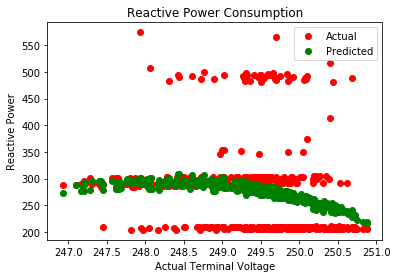

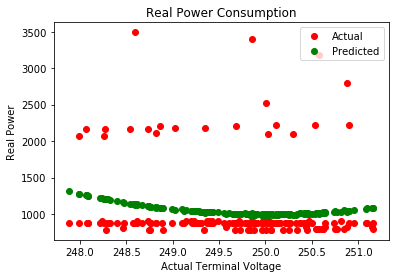

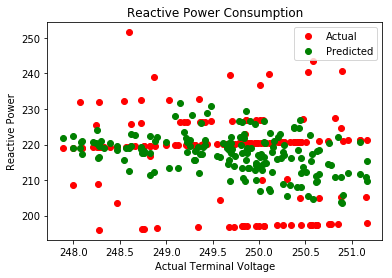

1 to 2


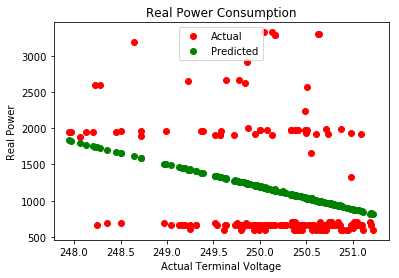

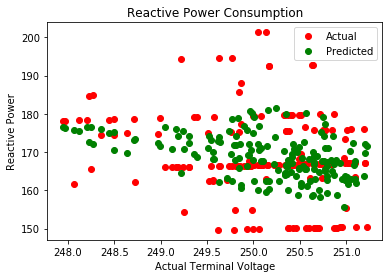

2 to 3


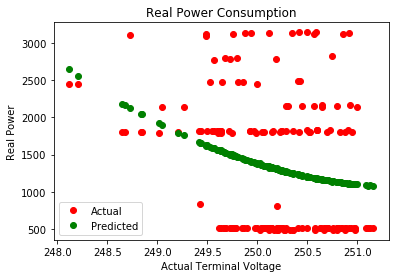

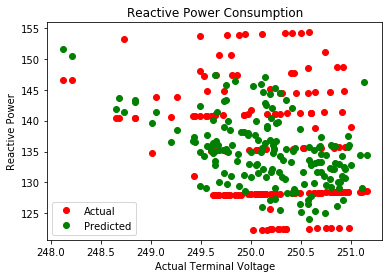

3 to 4


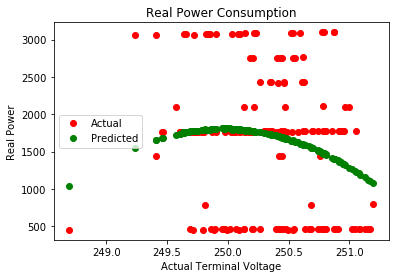

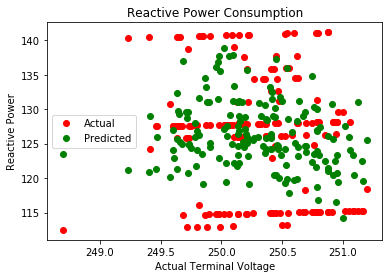

4 to 5


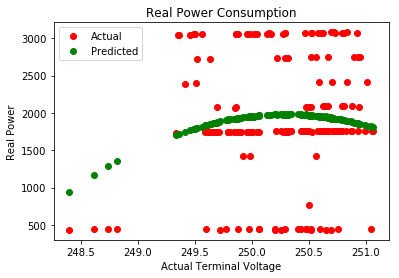

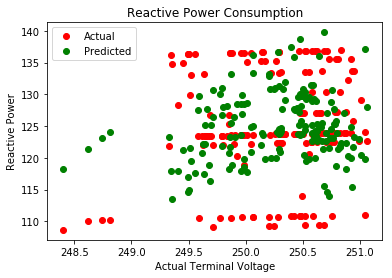

5 to 6


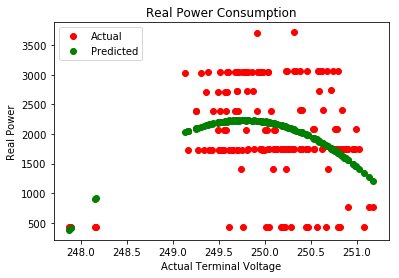

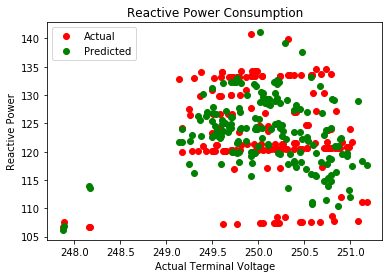

6 to 7


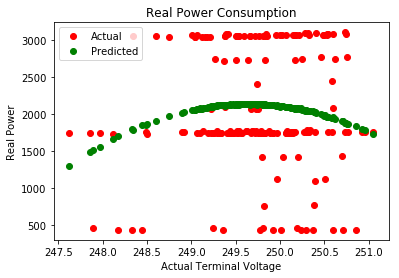

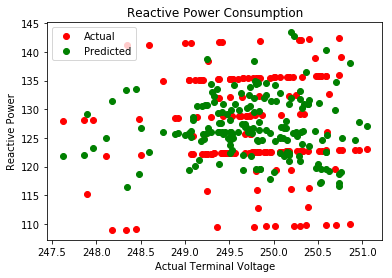

7 to 8


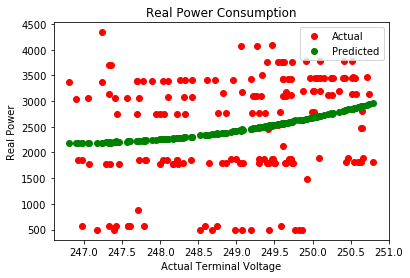

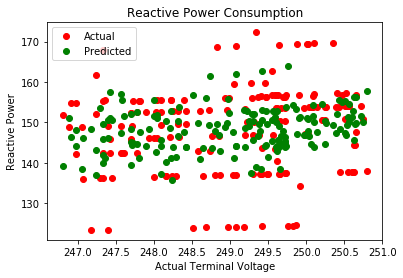

8 to 9


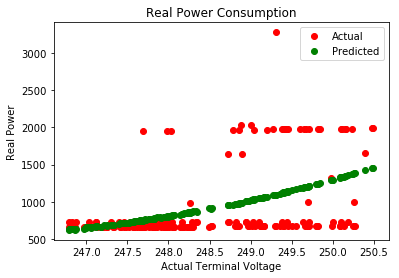

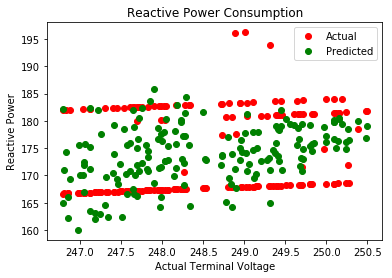

9 to 10


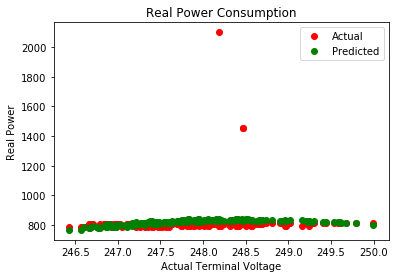

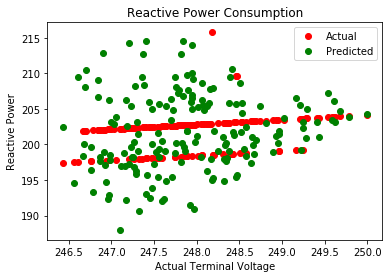

10 to 11


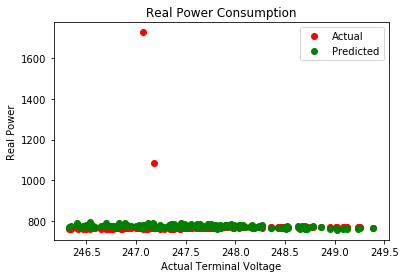

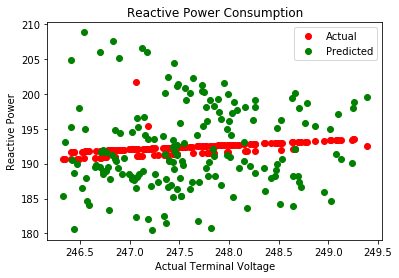

11 to 12


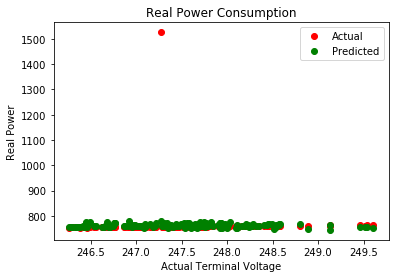

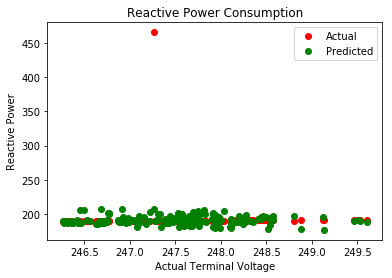

12 to 13


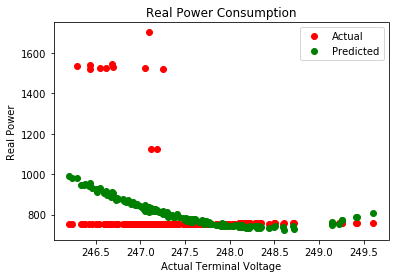

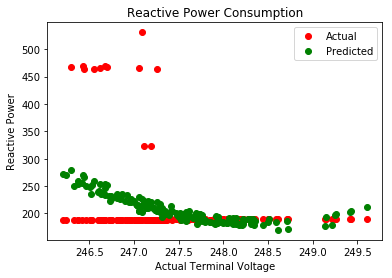

13 to 14


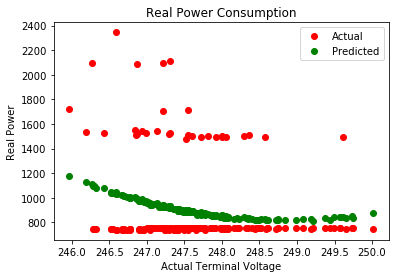

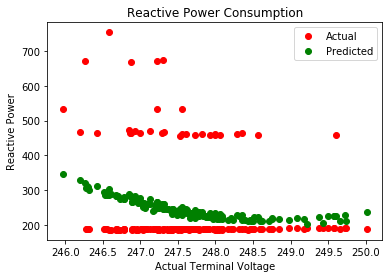

14 to 15


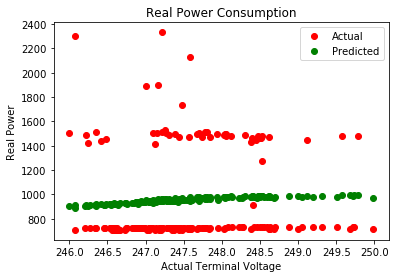

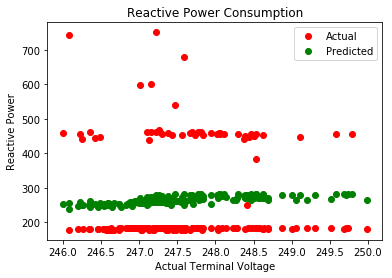

15 to 16


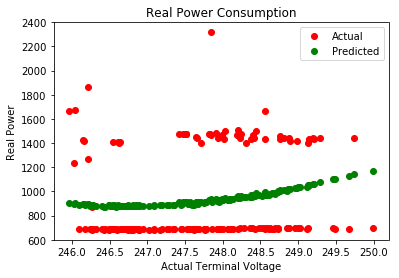

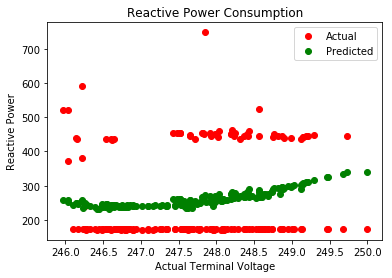

16 to 17


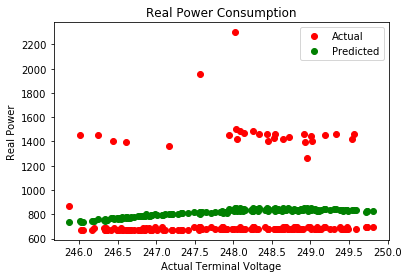

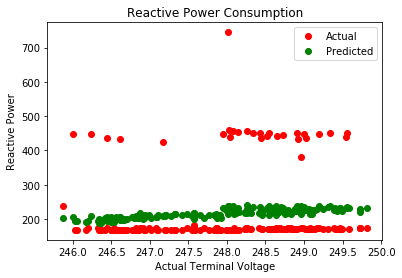

17 to 18


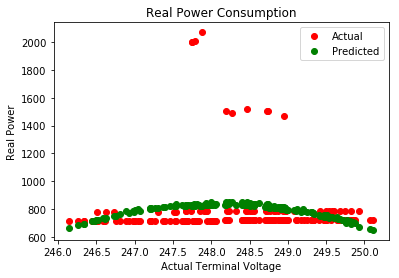

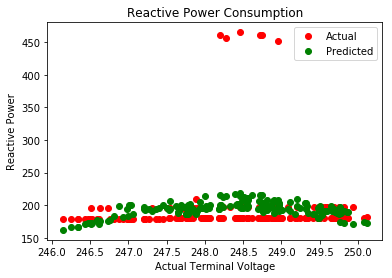

18 to 19


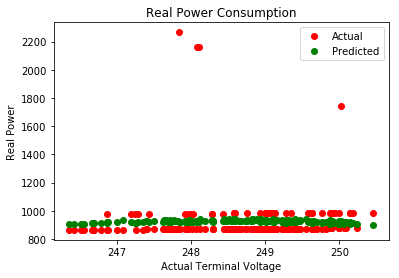

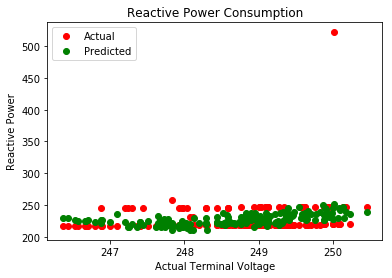

19 to 20


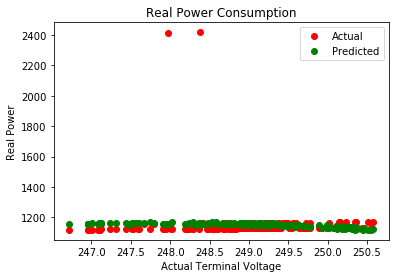

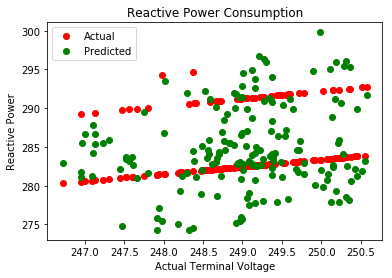

20 to 21


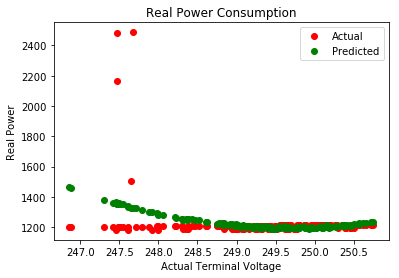

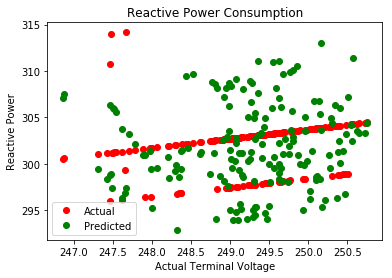

21 to 22


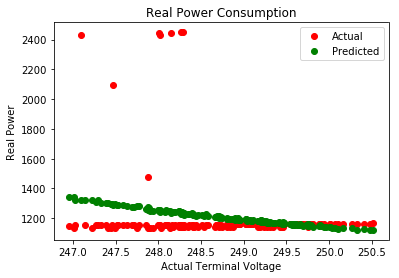

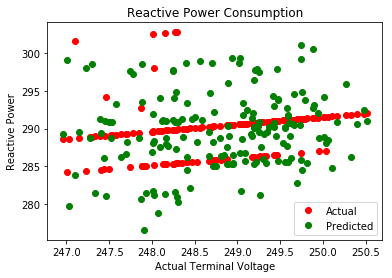

22 to 23


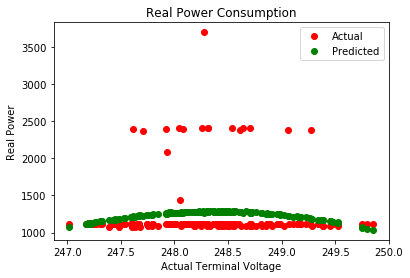

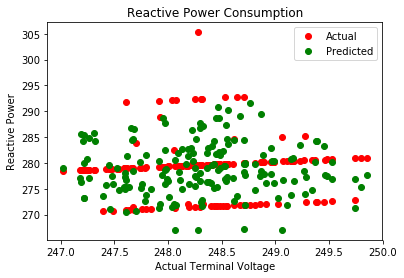

23 to 24


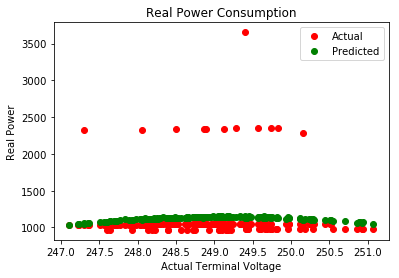

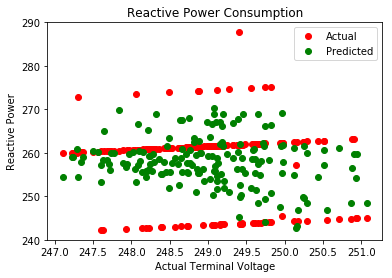

Weekends
0 to 1


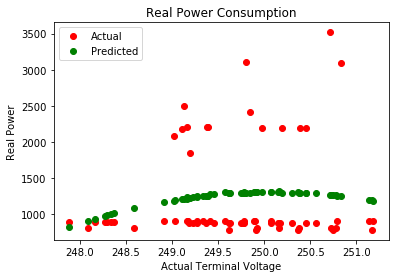

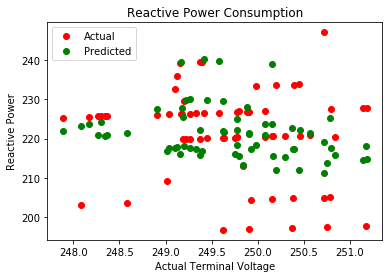

1 to 2


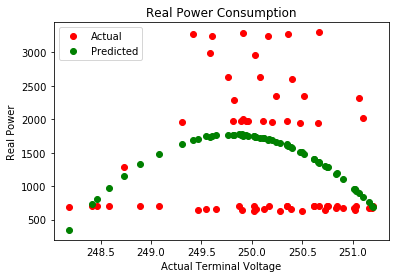

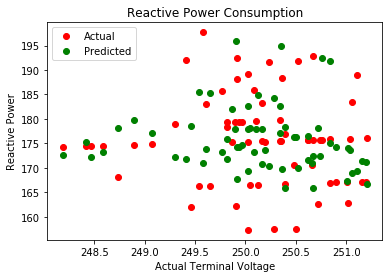

2 to 3


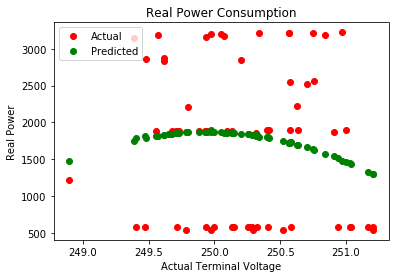

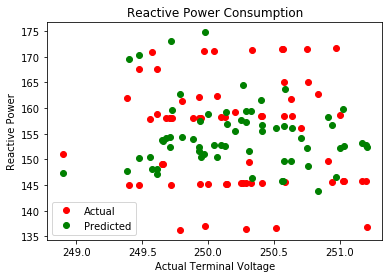

3 to 4


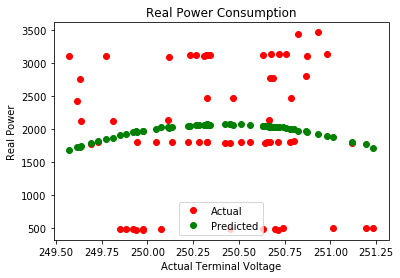

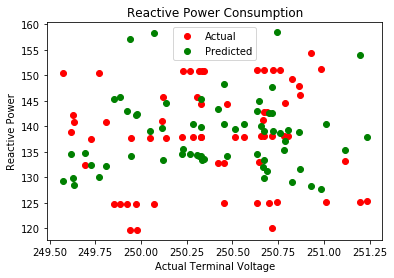

4 to 5


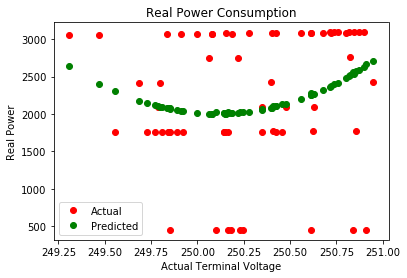

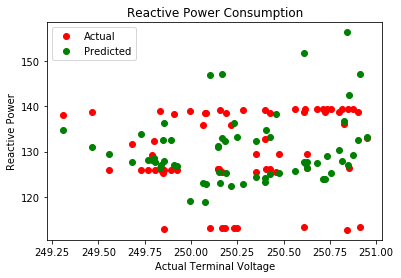

5 to 6


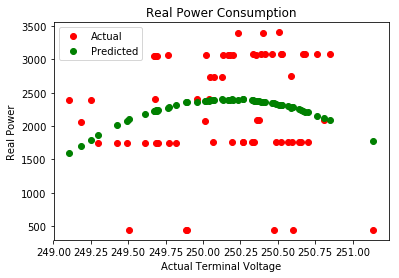

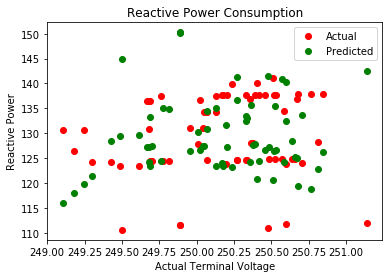

6 to 7


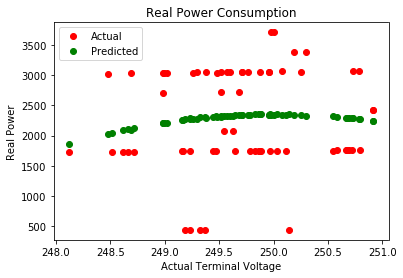

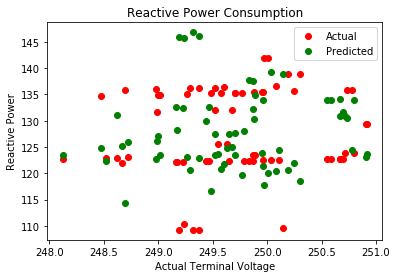

7 to 8


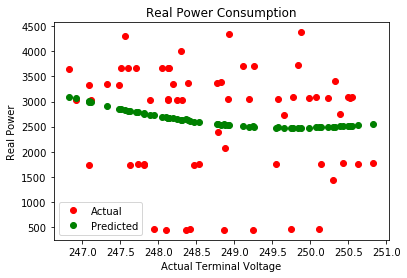

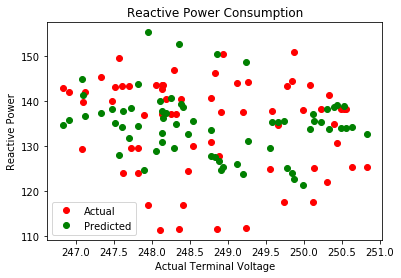

8 to 9


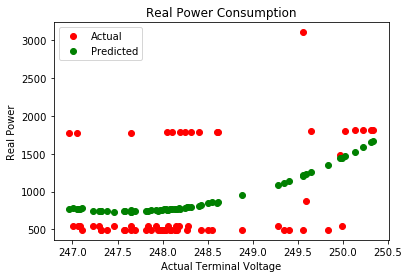

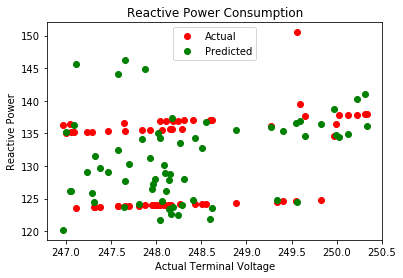

9 to 10


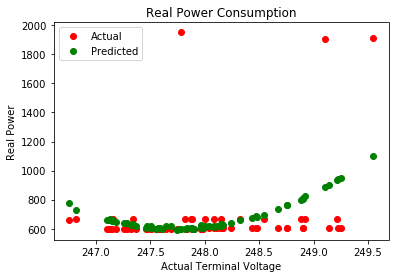

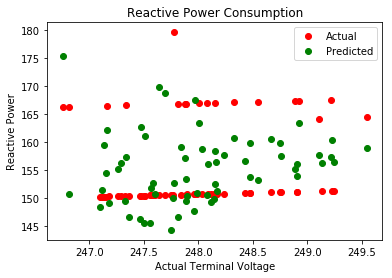

10 to 11


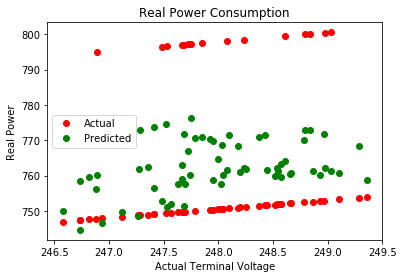

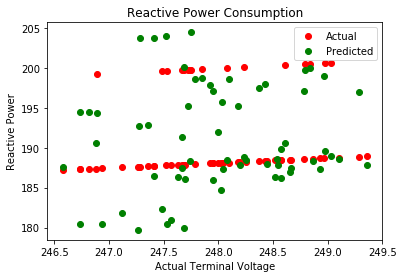

11 to 12


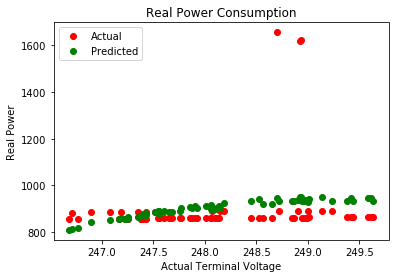

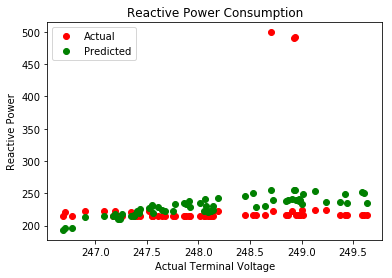

12 to 13


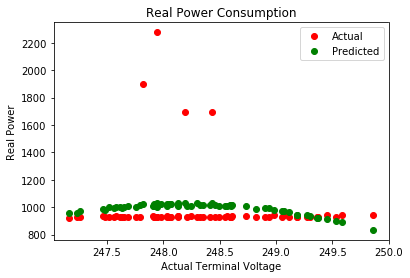

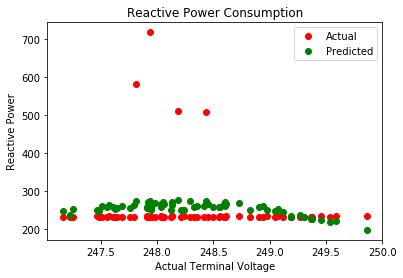

13 to 14


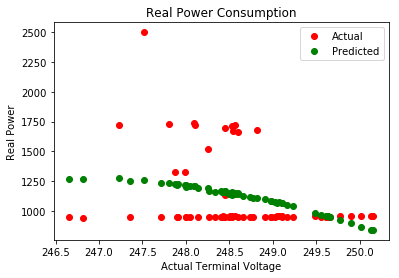

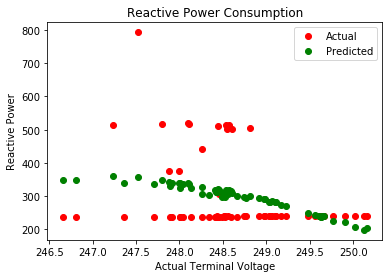

14 to 15


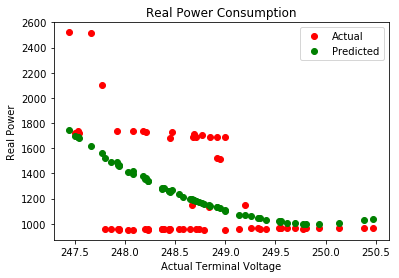

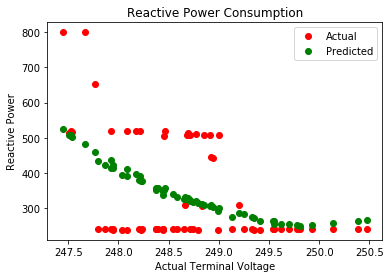

15 to 16


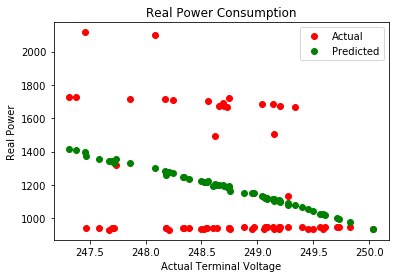

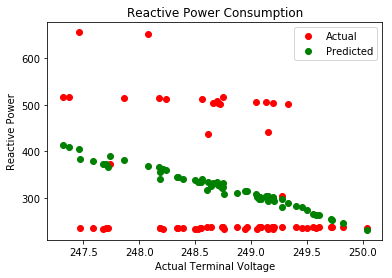

16 to 17


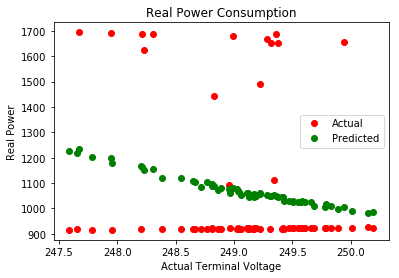

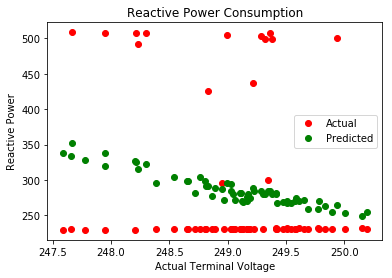

17 to 18


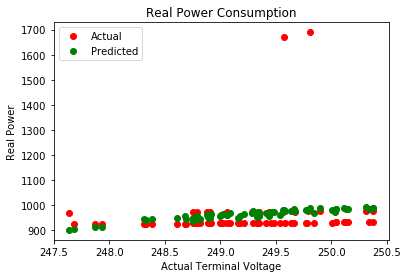

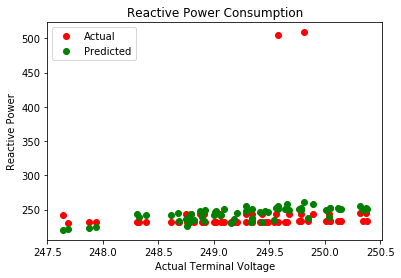

18 to 19


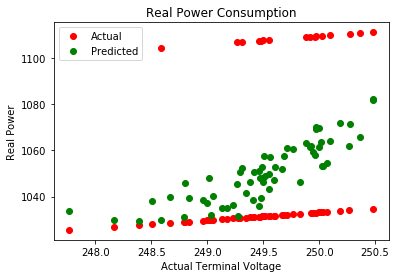

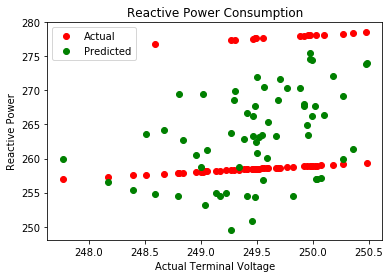

19 to 20


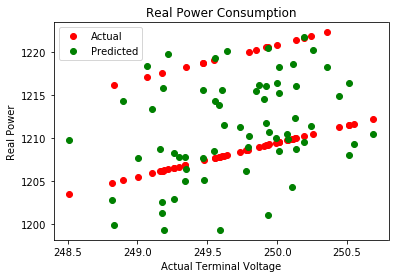

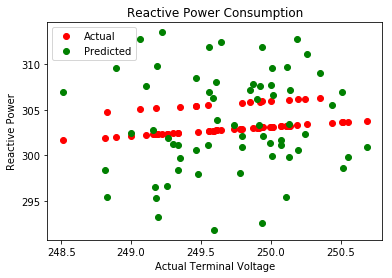

20 to 21


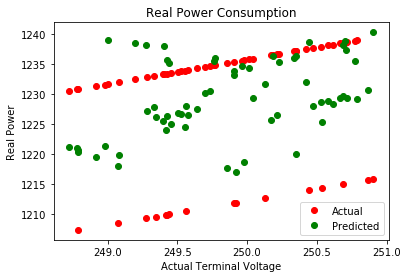

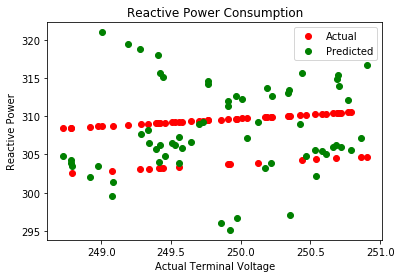

21 to 22


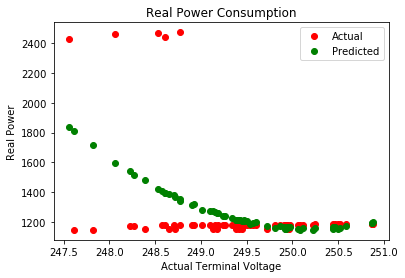

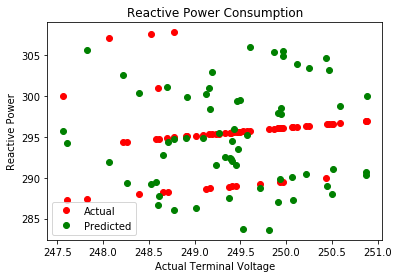

22 to 23


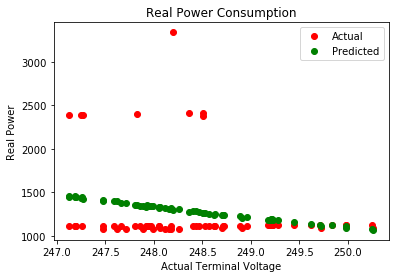

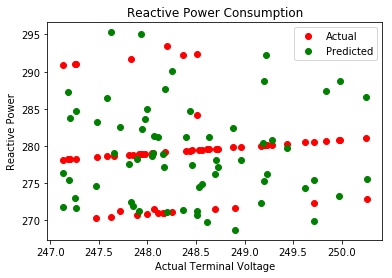

23 to 24


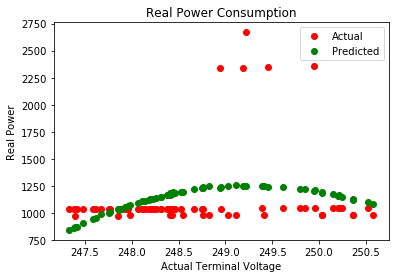

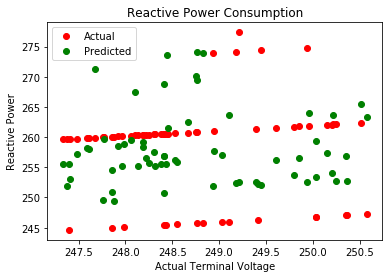

Season  2
2013-03-01
2013-05-15
Weekdays
0 to 1


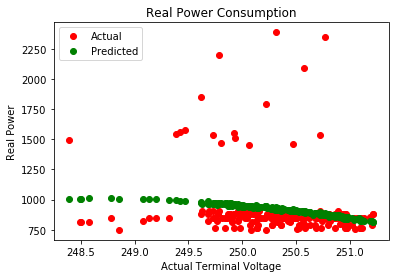

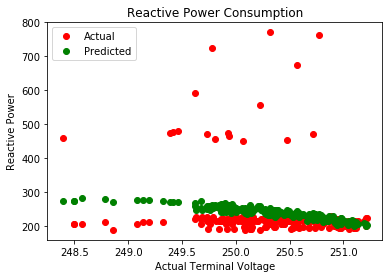

1 to 2


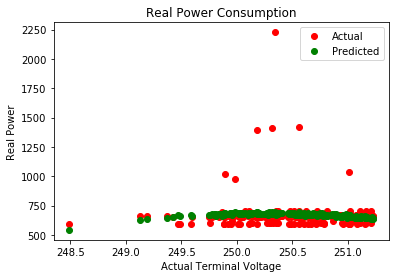

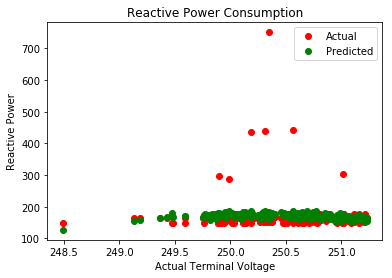

2 to 3


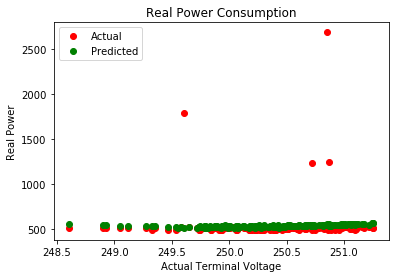

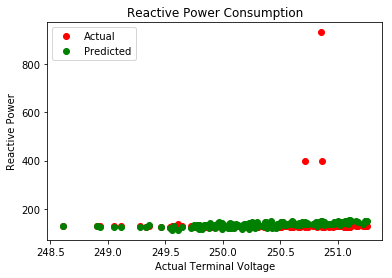

3 to 4


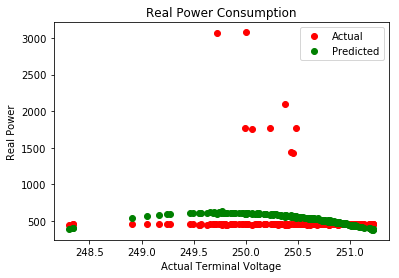

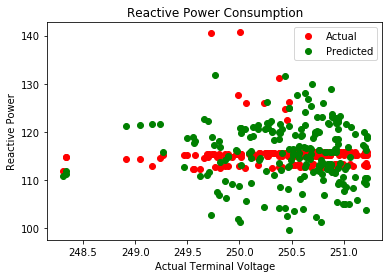

4 to 5


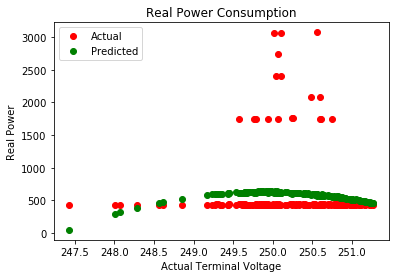

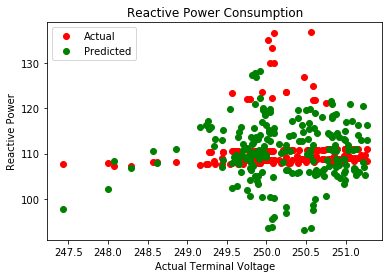

5 to 6


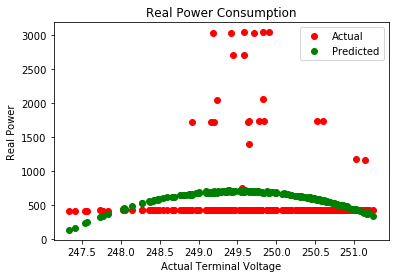

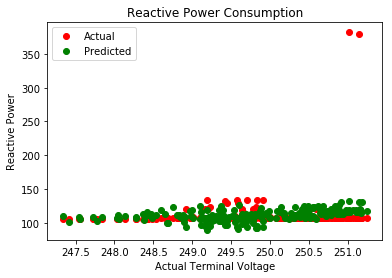

6 to 7


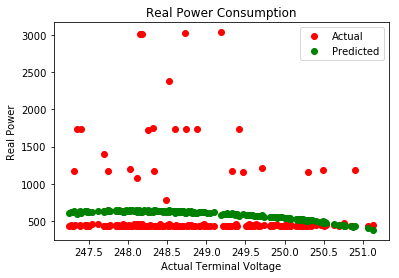

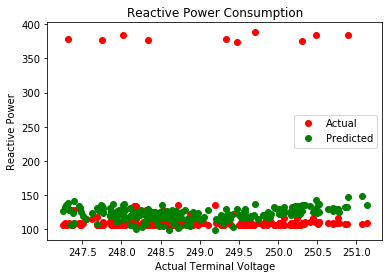

7 to 8


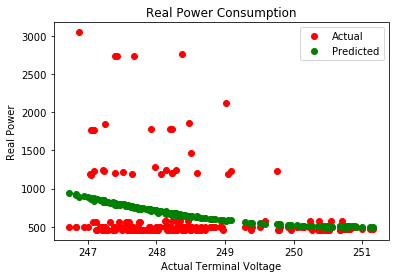

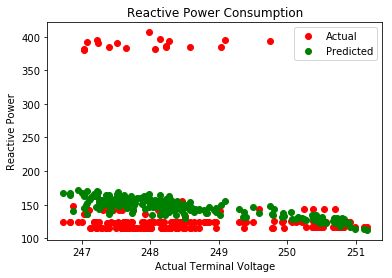

8 to 9


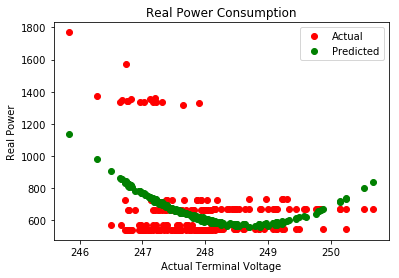

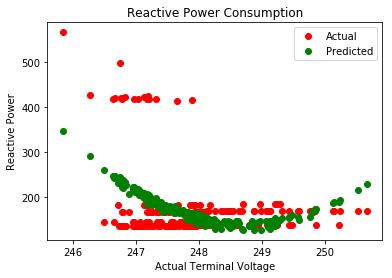

9 to 10


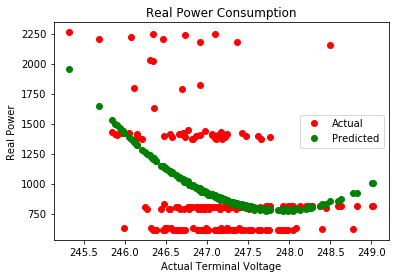

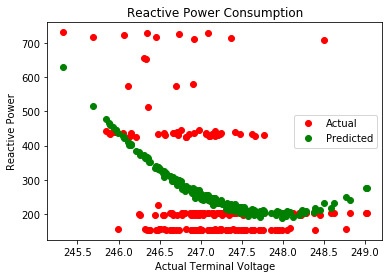

10 to 11


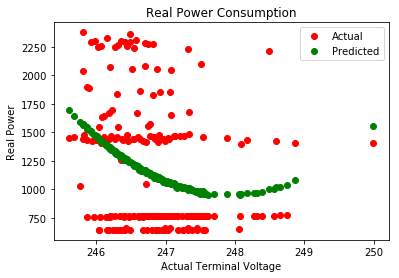

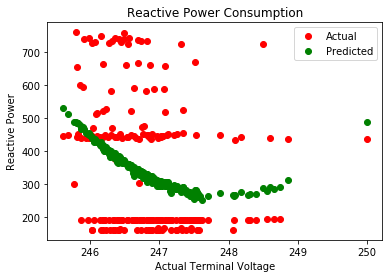

11 to 12


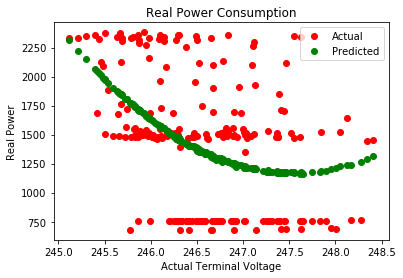

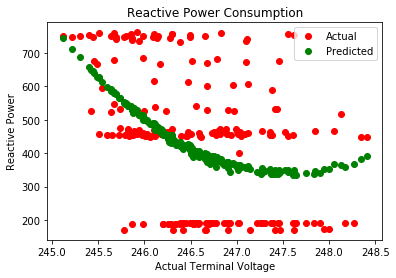

12 to 13


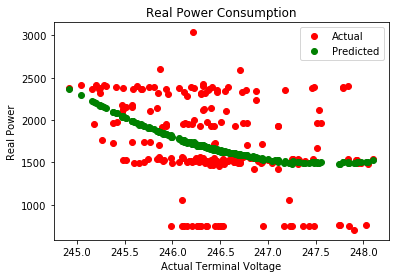

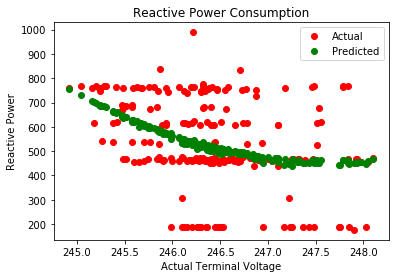

13 to 14


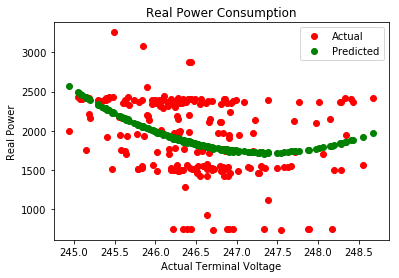

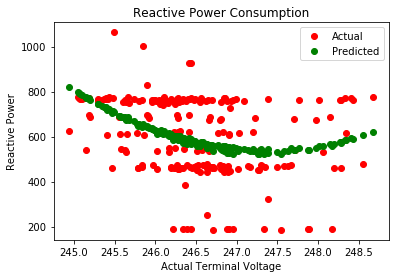

14 to 15


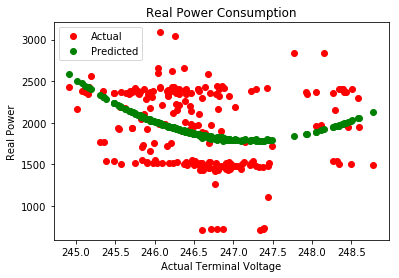

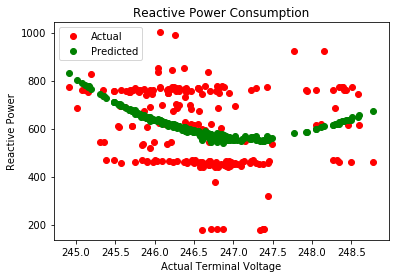

15 to 16


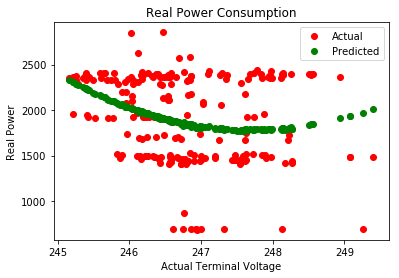

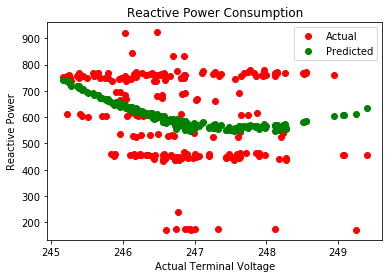

16 to 17


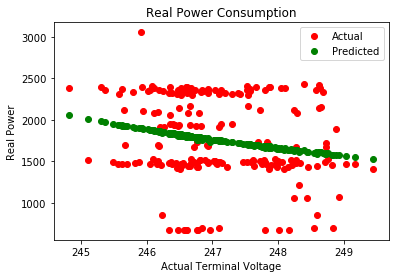

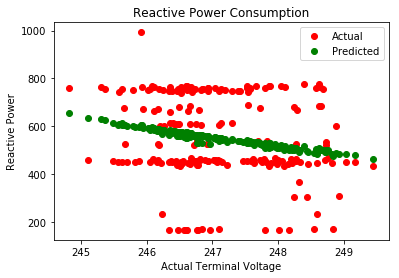

17 to 18


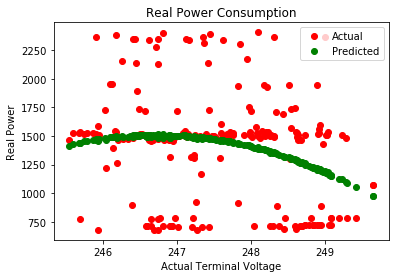

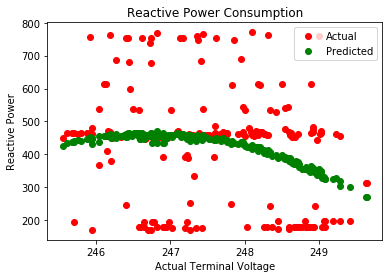

18 to 19


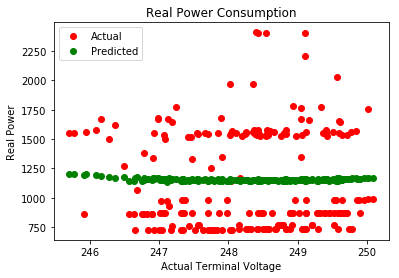

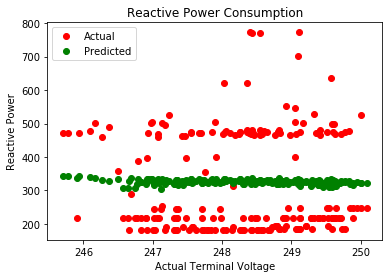

19 to 20


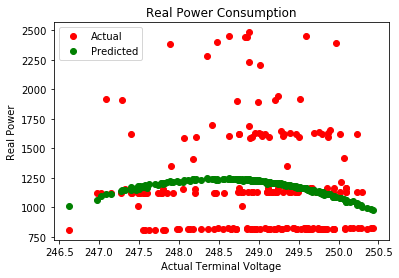

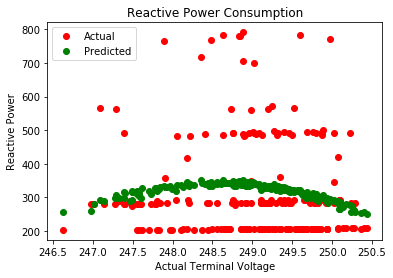

20 to 21


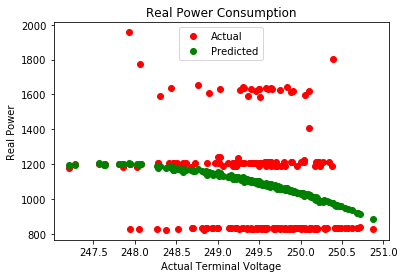

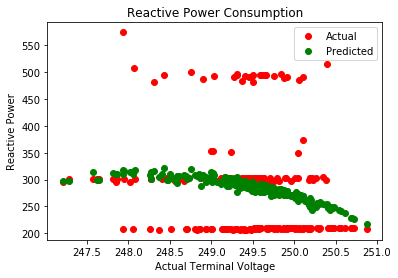

21 to 22


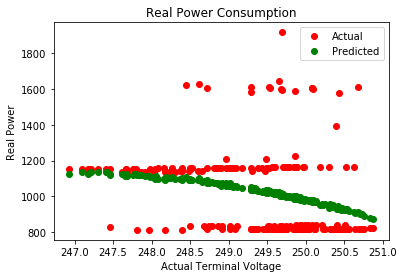

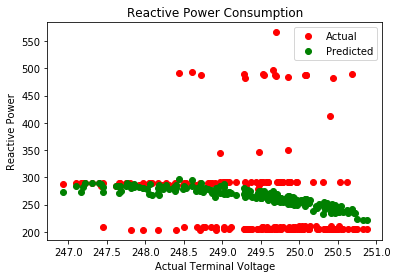

22 to 23


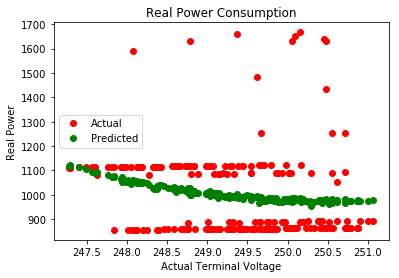

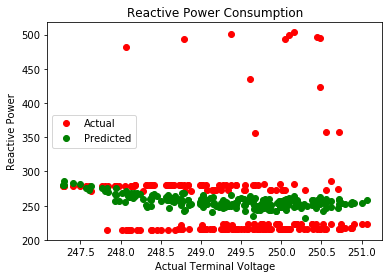

23 to 24


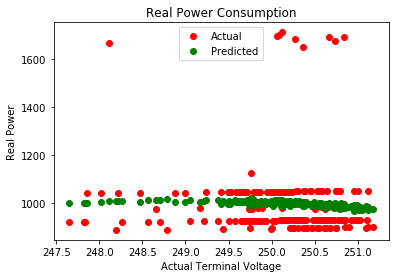

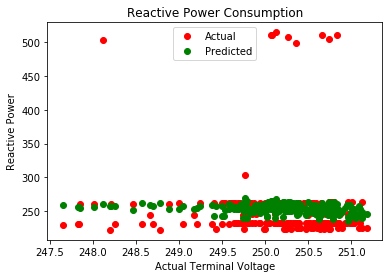

Weekends
0 to 1


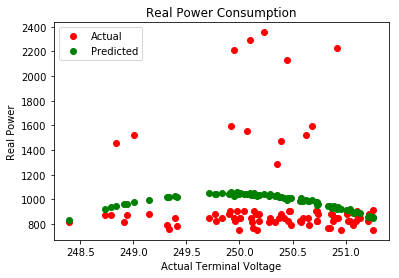

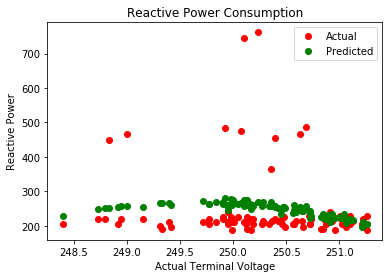

1 to 2


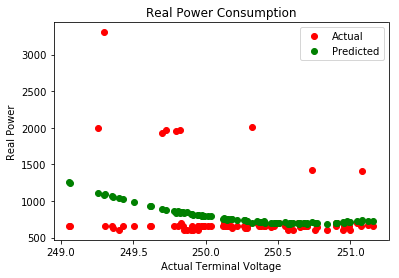

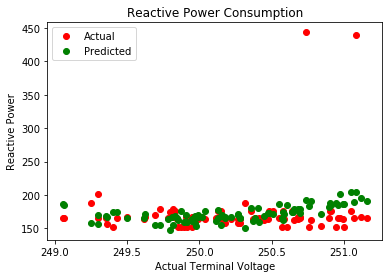

2 to 3


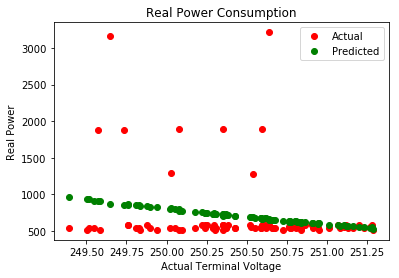

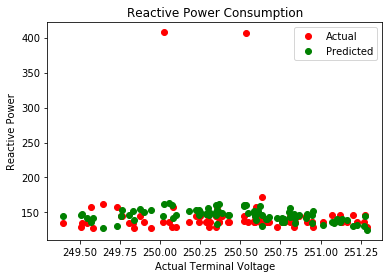

3 to 4


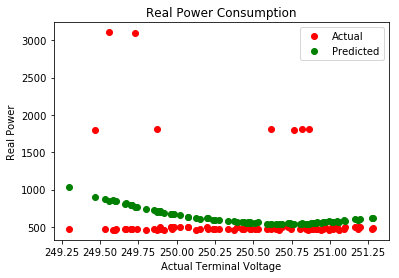

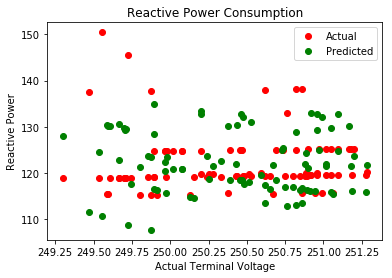

4 to 5


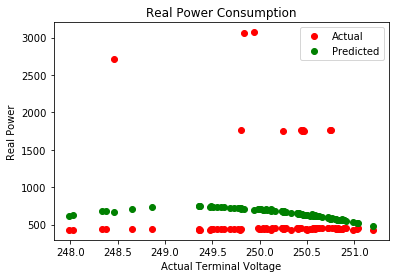

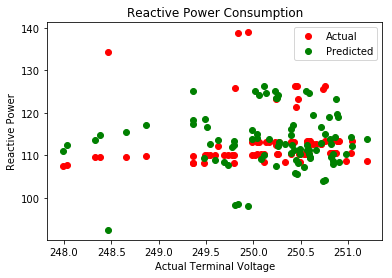

5 to 6


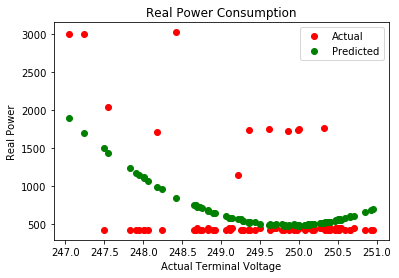

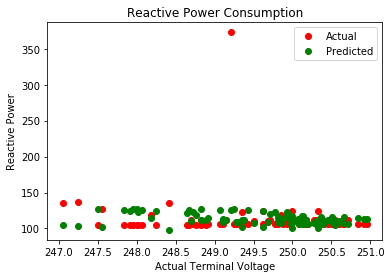

6 to 7


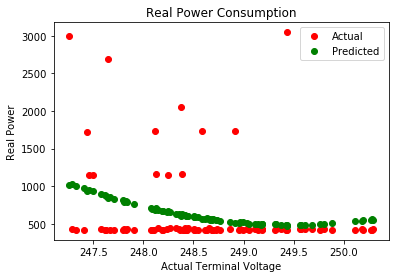

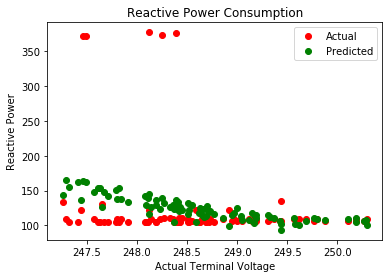

7 to 8


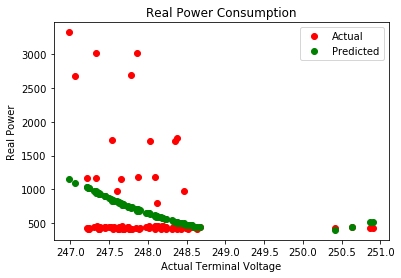

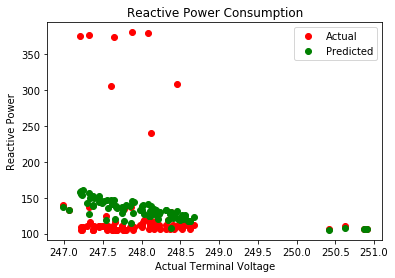

8 to 9


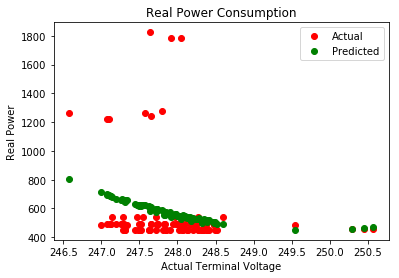

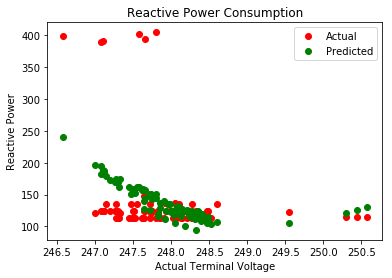

9 to 10


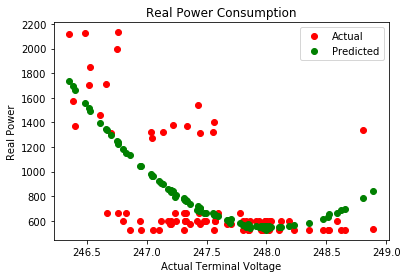

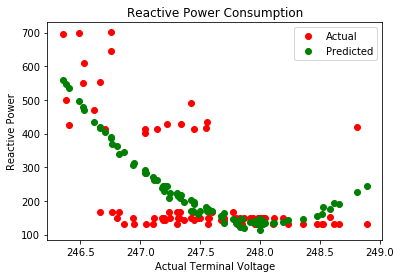

10 to 11


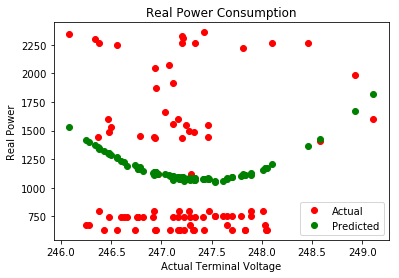

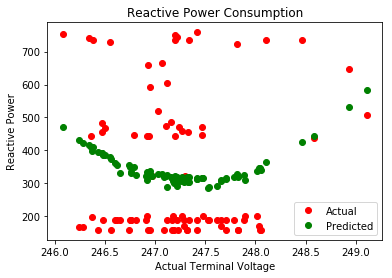

11 to 12


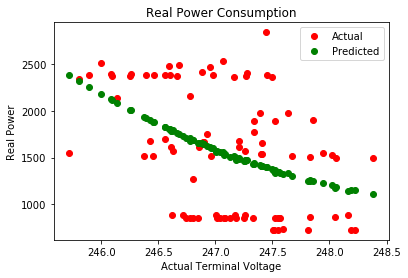

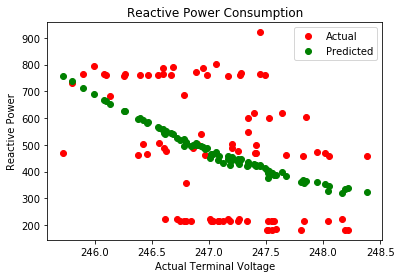

12 to 13


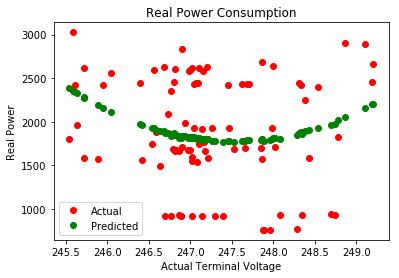

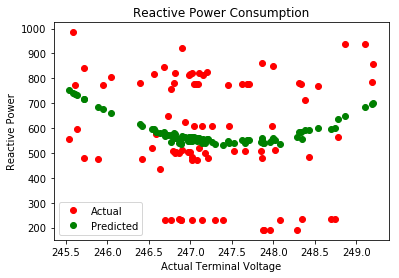

13 to 14


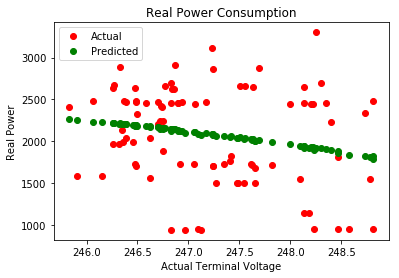

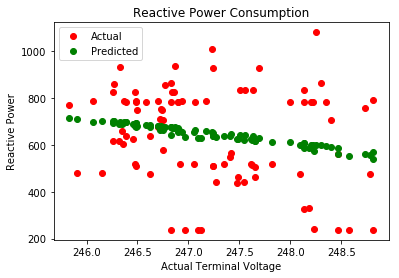

14 to 15


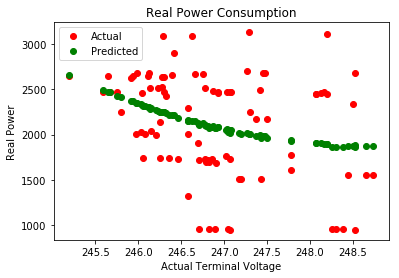

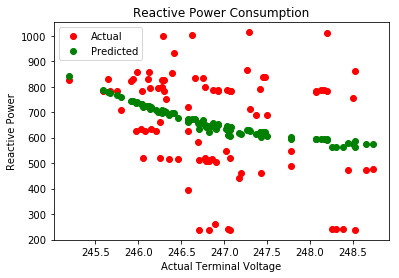

15 to 16


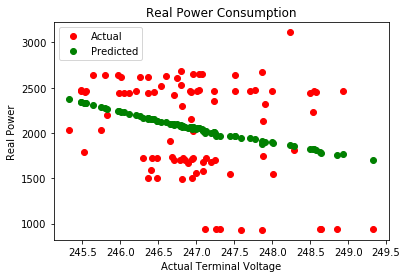

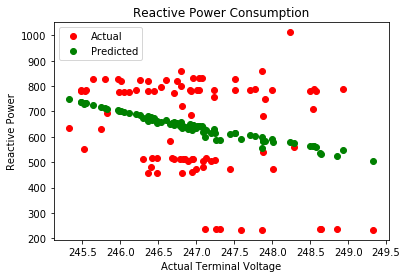

16 to 17


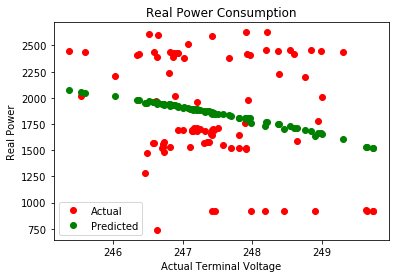

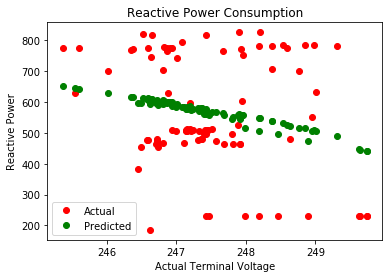

17 to 18


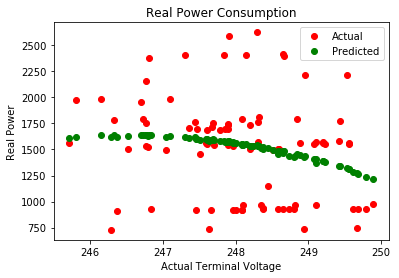

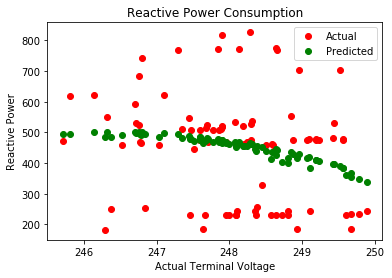

18 to 19


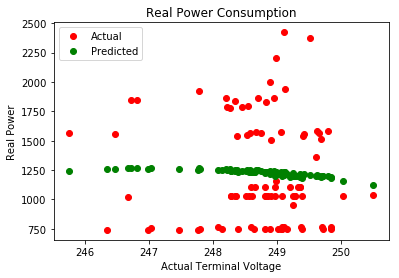

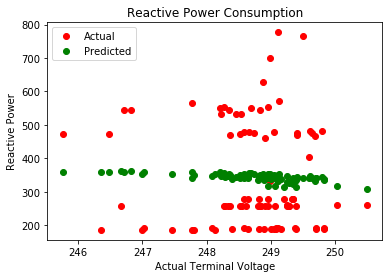

19 to 20


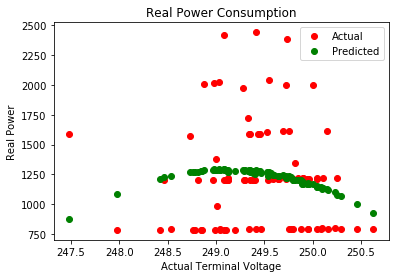

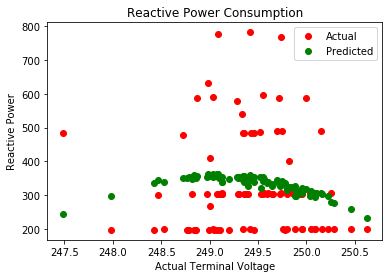

20 to 21


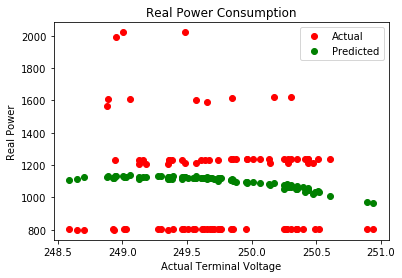

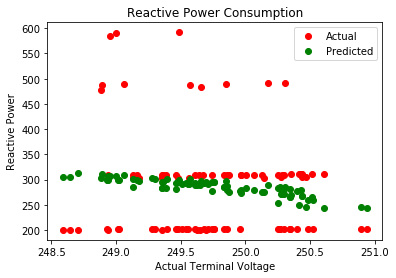

21 to 22


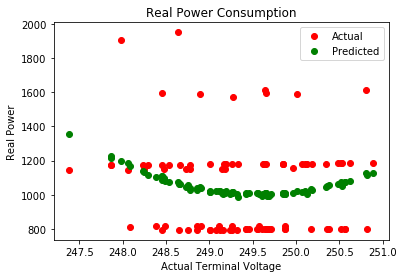

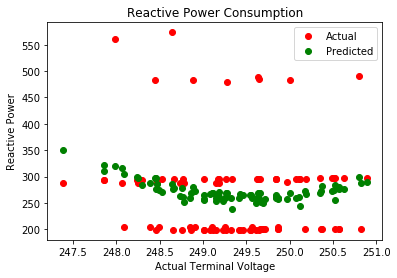

22 to 23


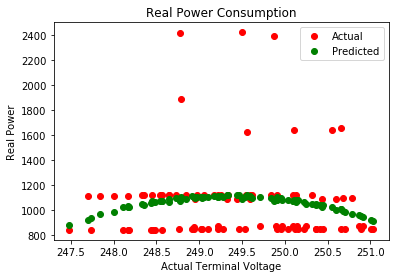

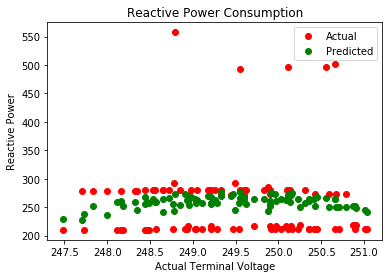

23 to 24


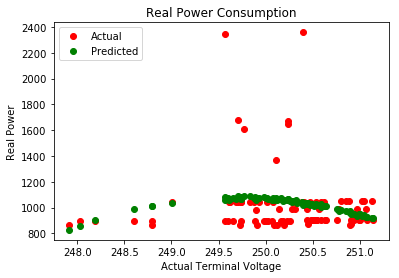

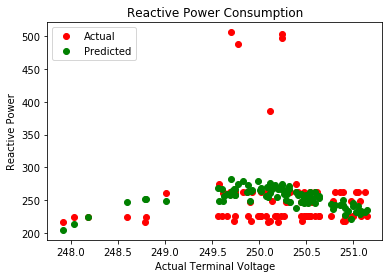

HOUR WINDOW IS 2
Season  1
2013-01-01
2013-03-01
Weekdays
0 to 2


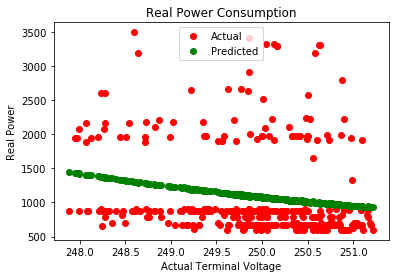

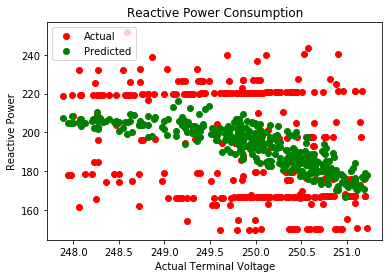

2 to 4


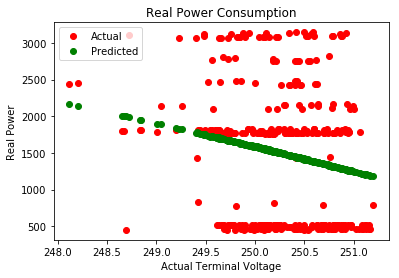

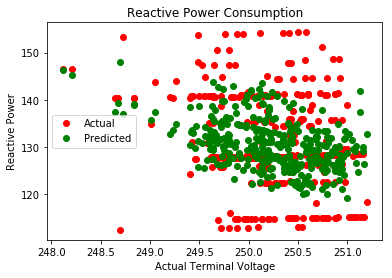

4 to 6


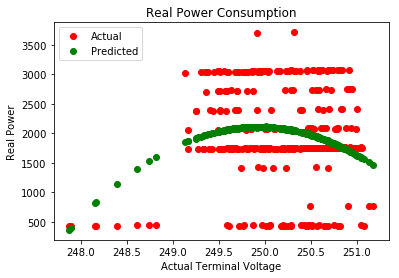

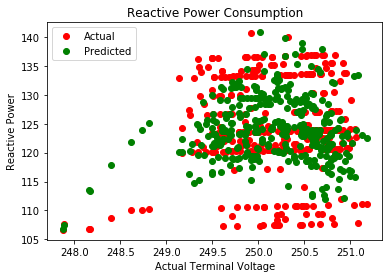

6 to 8


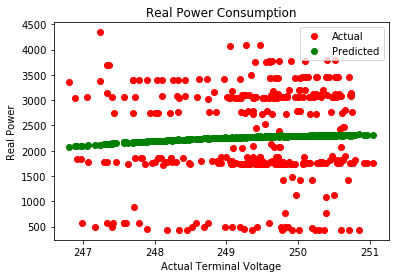

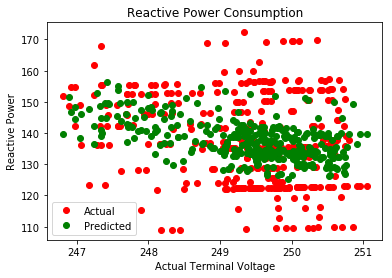

8 to 10


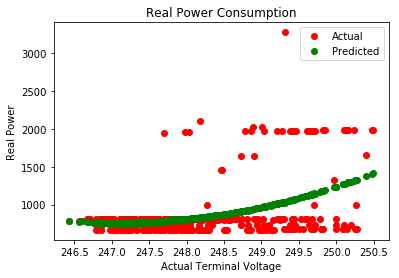

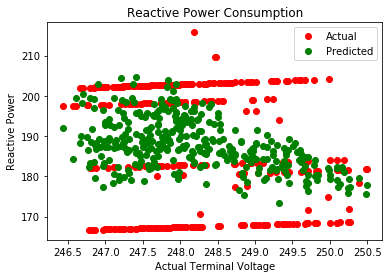

10 to 12


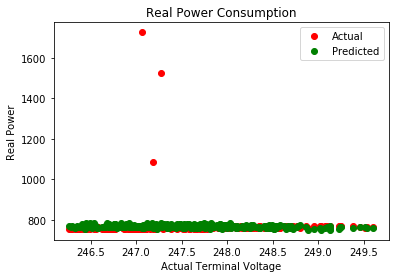

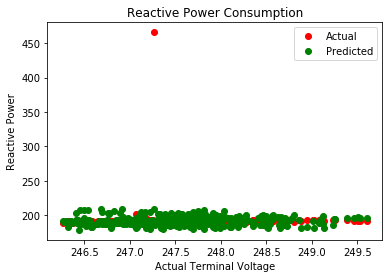

12 to 14


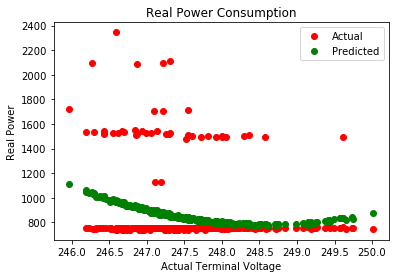

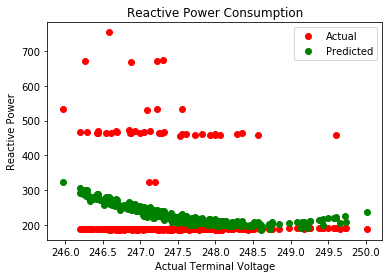

14 to 16


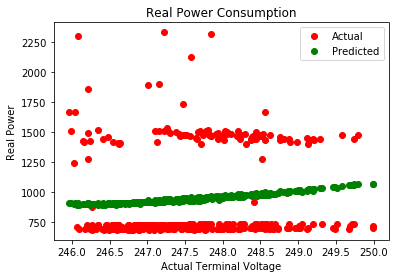

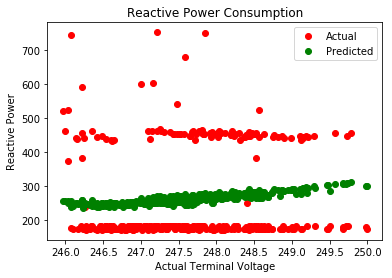

16 to 18


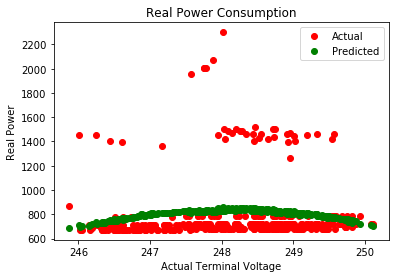

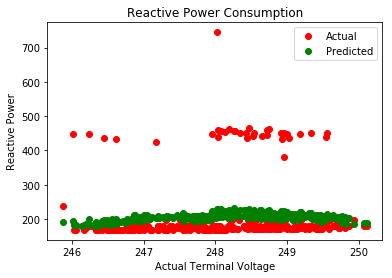

18 to 20


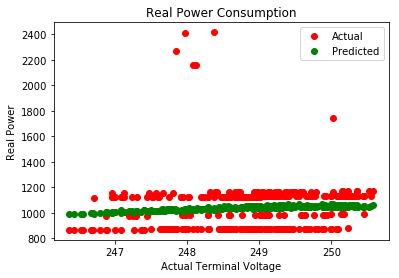

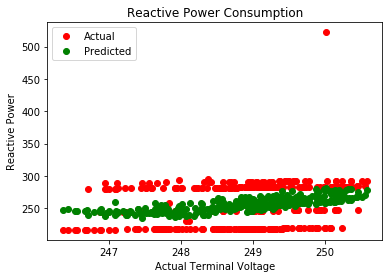

20 to 22


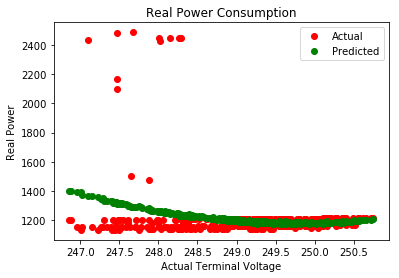

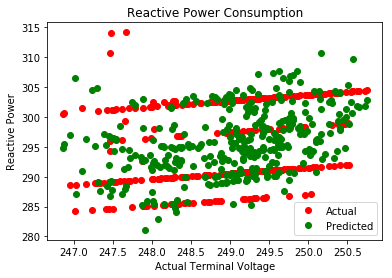

22 to 24


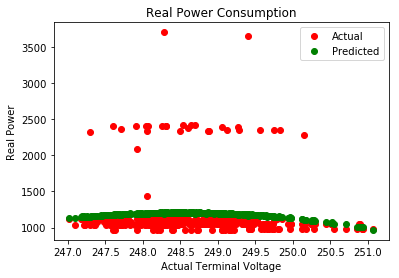

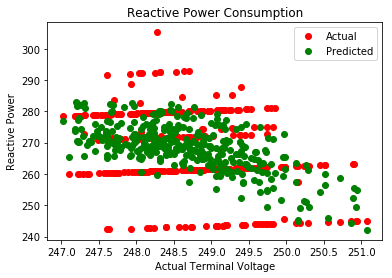

Weekends
0 to 2


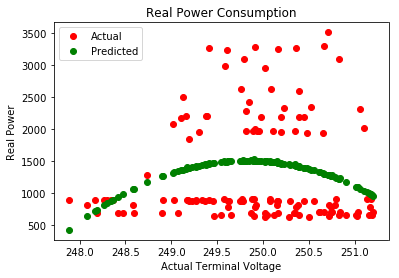

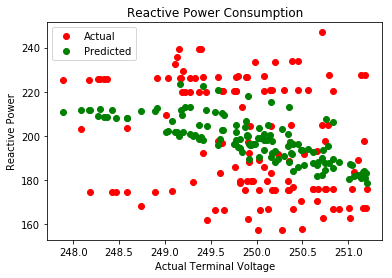

2 to 4


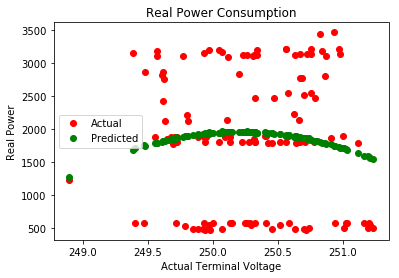

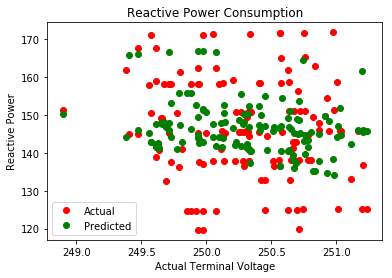

4 to 6


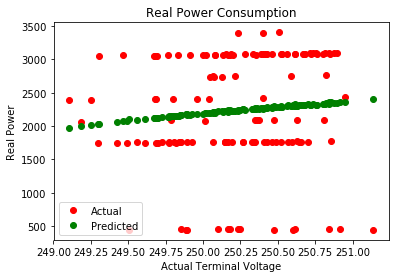

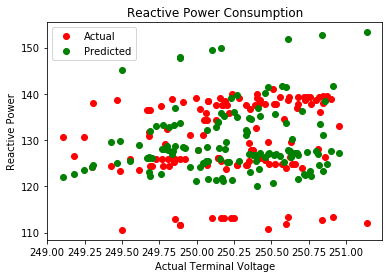

6 to 8


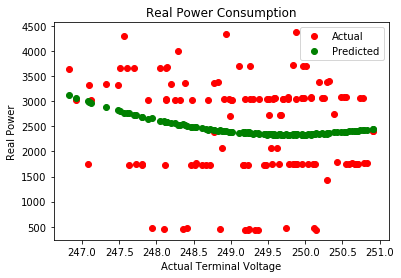

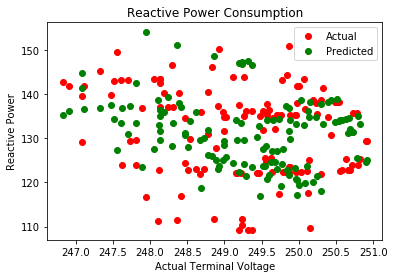

8 to 10


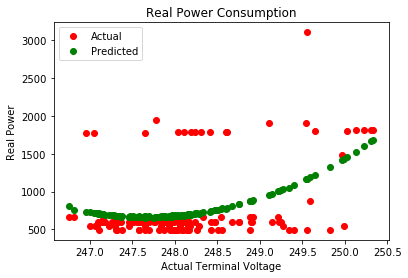

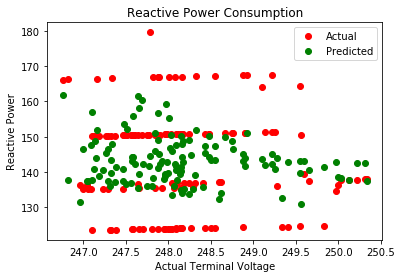

10 to 12


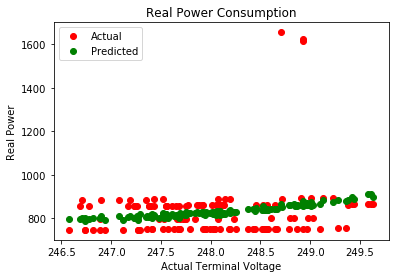

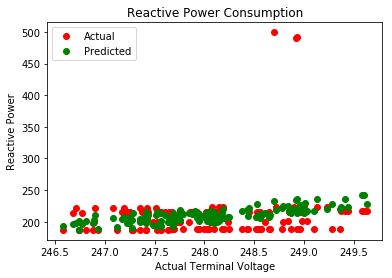

12 to 14


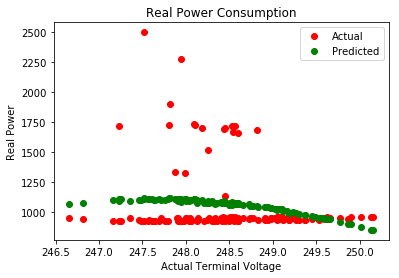

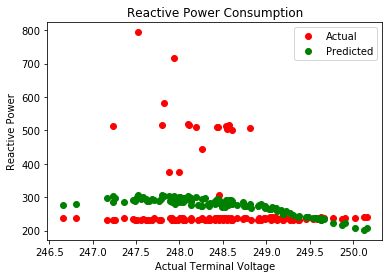

14 to 16


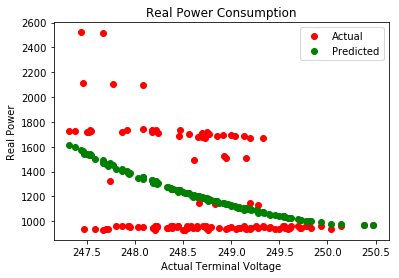

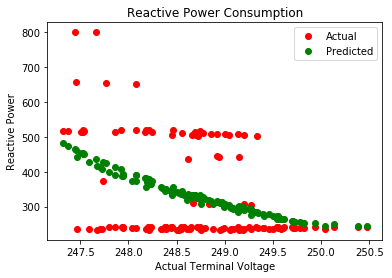

16 to 18


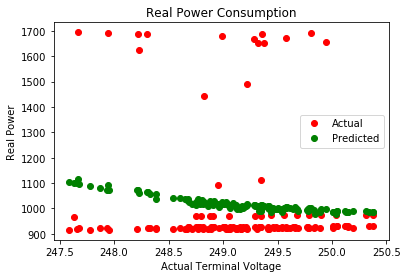

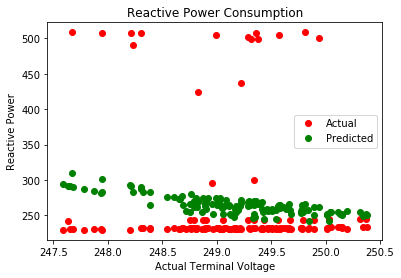

18 to 20


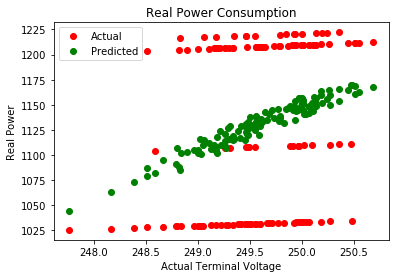

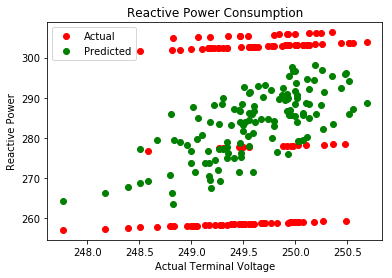

20 to 22


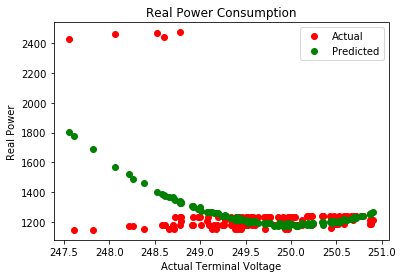

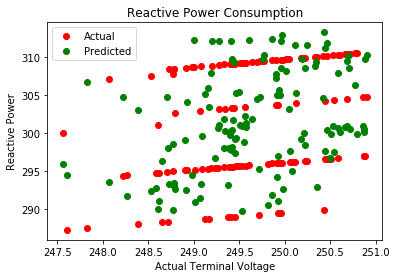

22 to 24


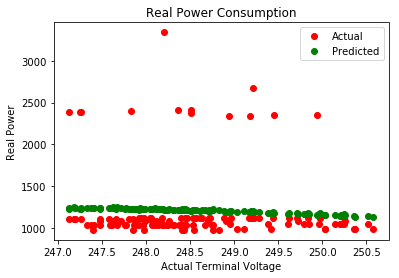

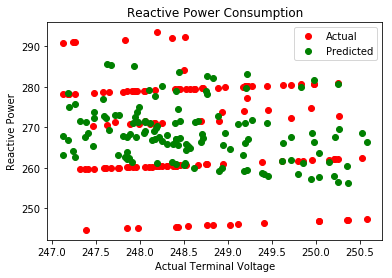

Season  2
2013-03-01
2013-05-15
Weekdays
0 to 2


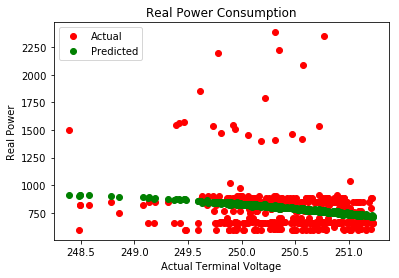

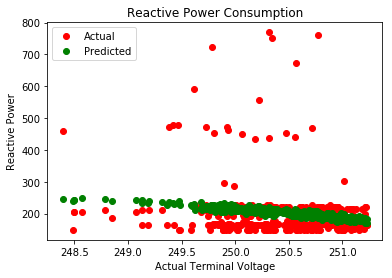

2 to 4


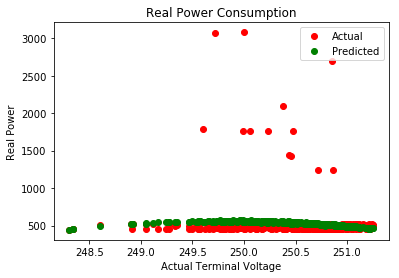

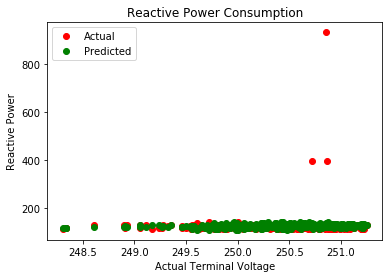

4 to 6


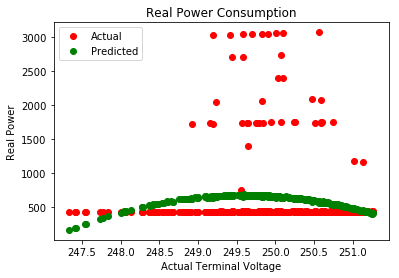

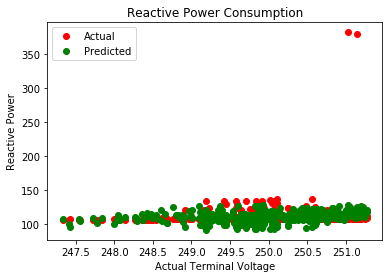

6 to 8


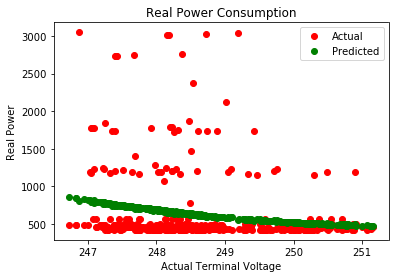

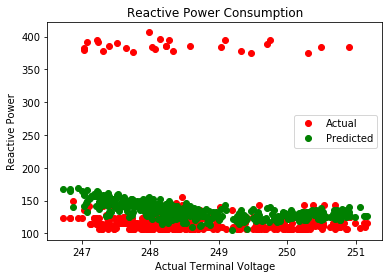

8 to 10


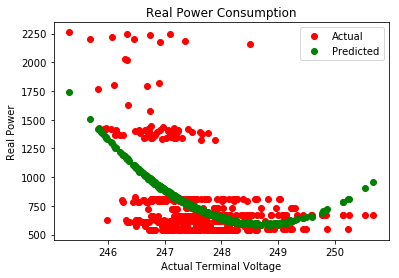

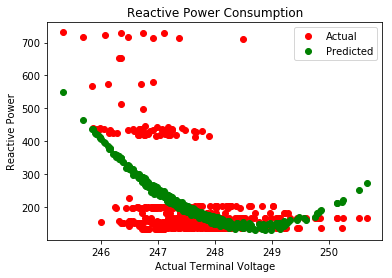

10 to 12


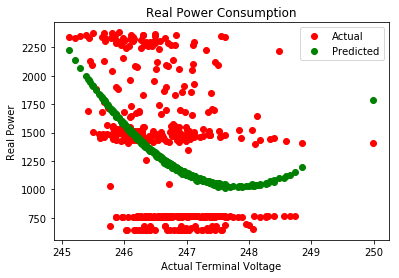

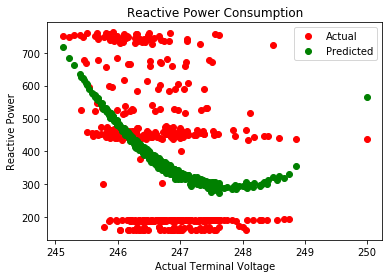

12 to 14


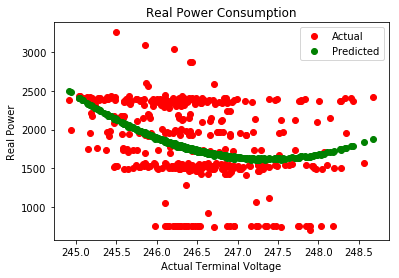

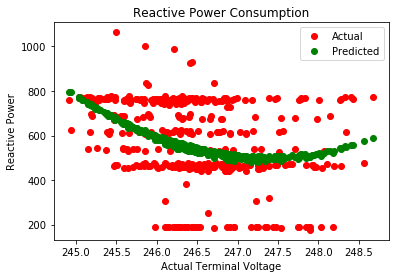

14 to 16


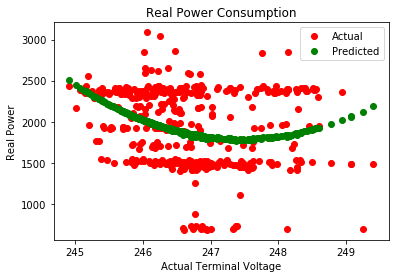

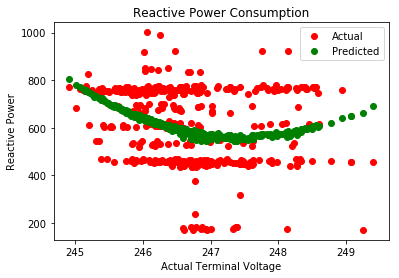

16 to 18


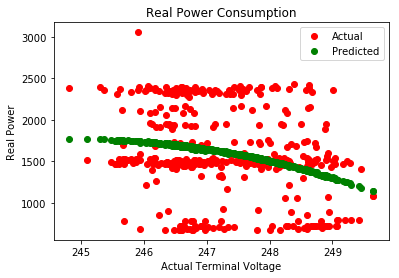

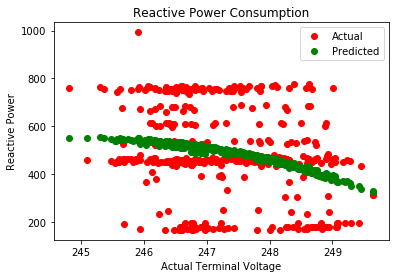

18 to 20


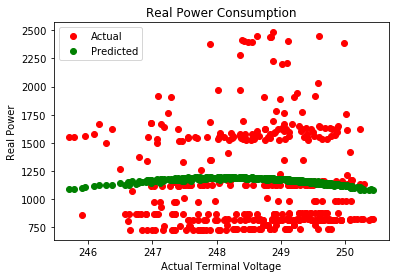

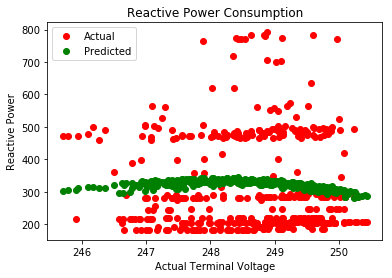

20 to 22


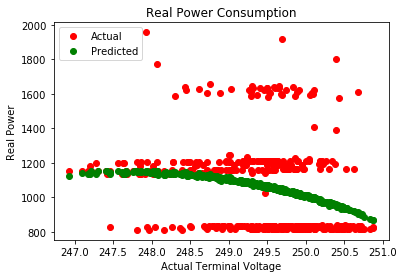

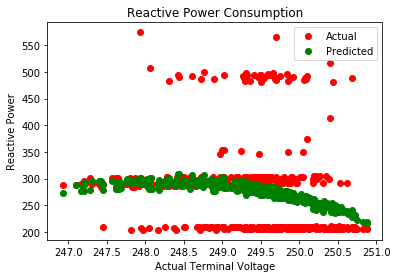

22 to 24


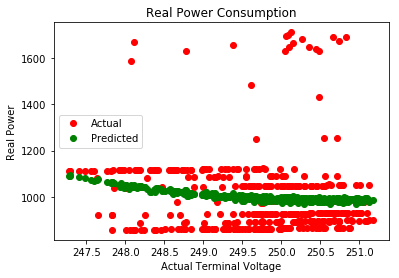

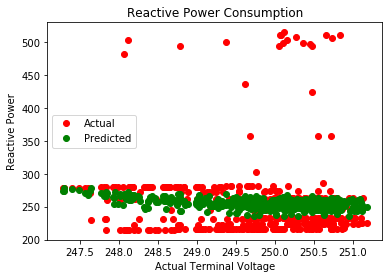

Weekends
0 to 2


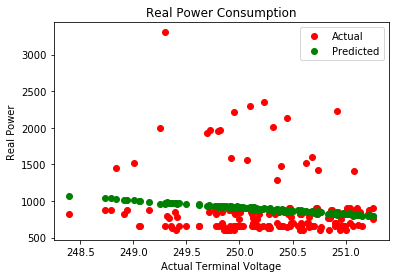

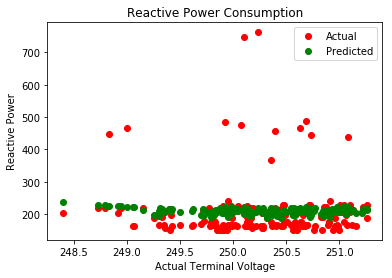

2 to 4


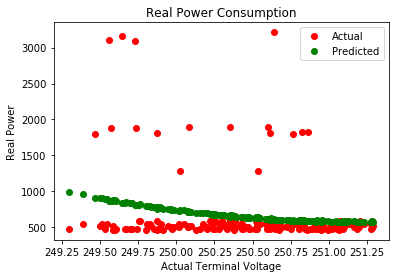

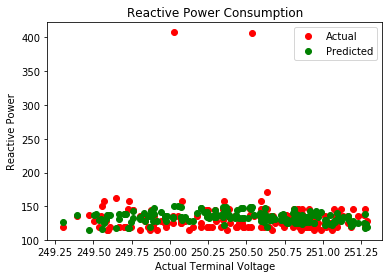

4 to 6


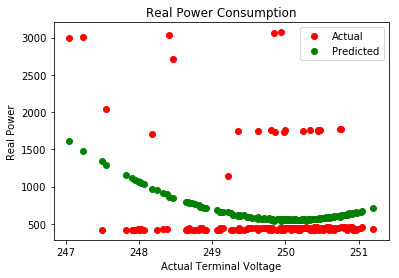

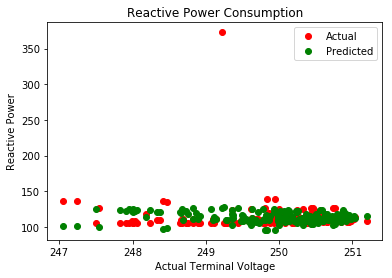

6 to 8


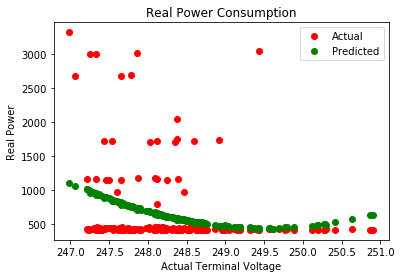

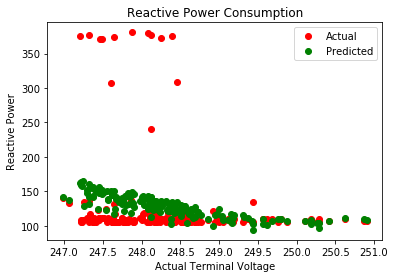

8 to 10


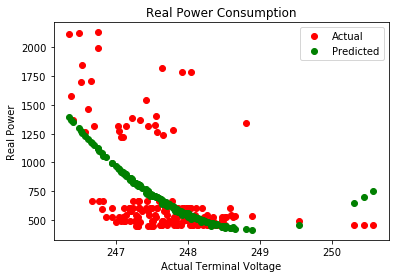

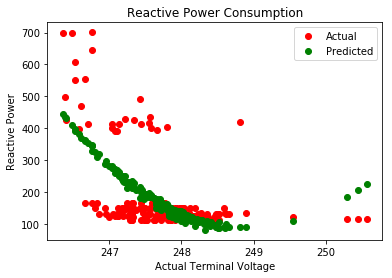

10 to 12


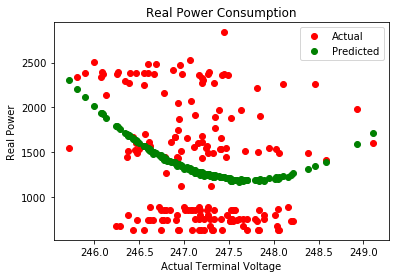

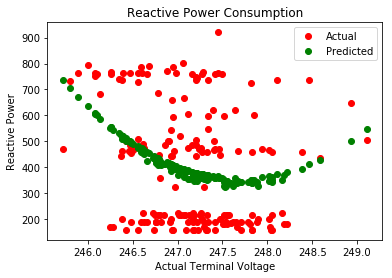

12 to 14


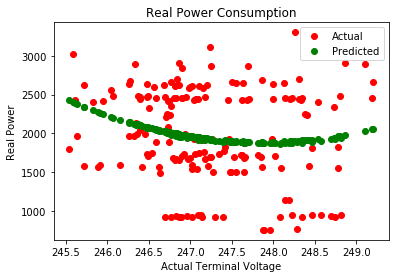

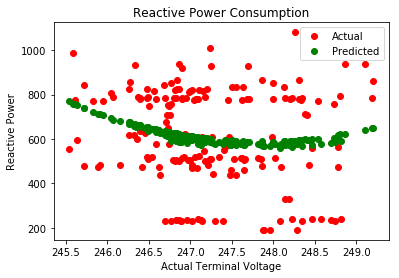

14 to 16


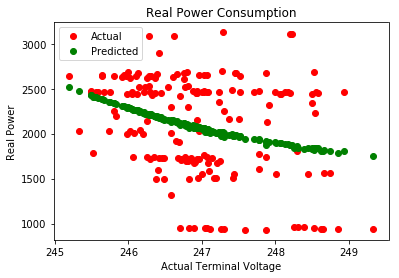

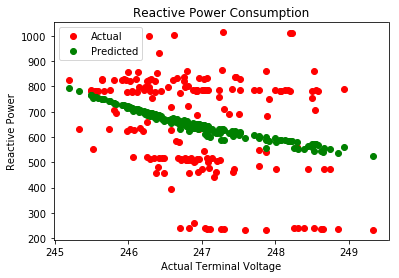

16 to 18


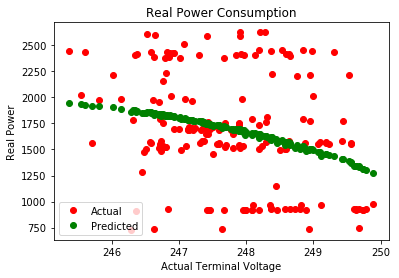

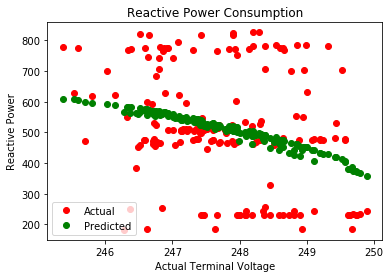

18 to 20


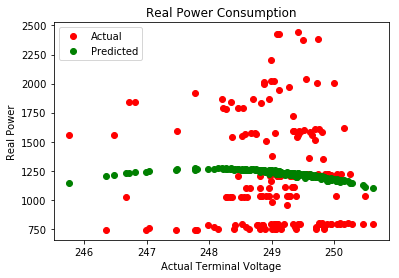

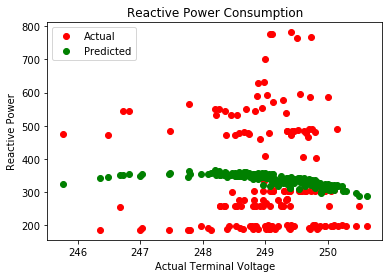

20 to 22


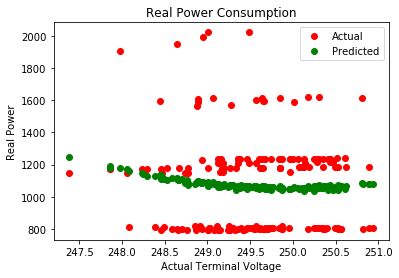

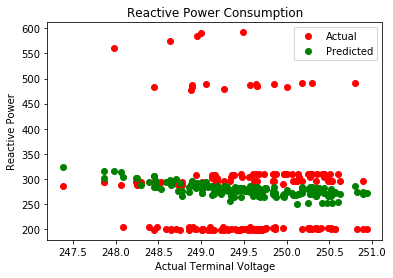

22 to 24


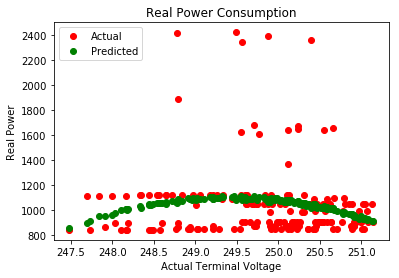

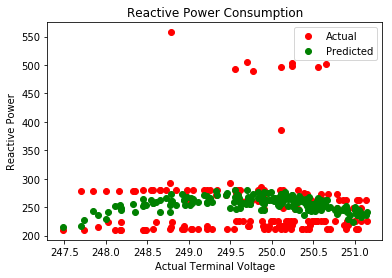

HOUR WINDOW IS 4
Season  1
2013-01-01
2013-03-01
Weekdays
0 to 4


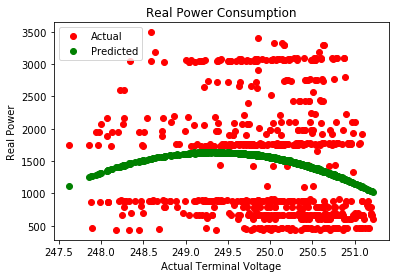

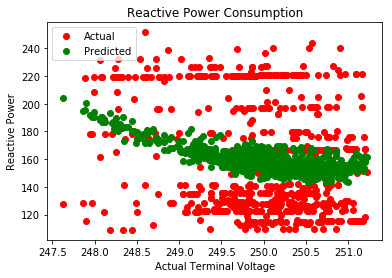

4 to 8


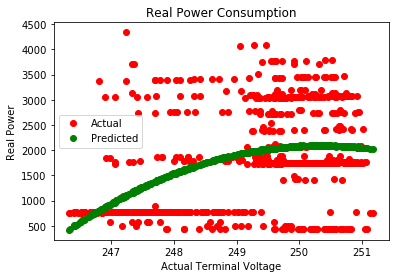

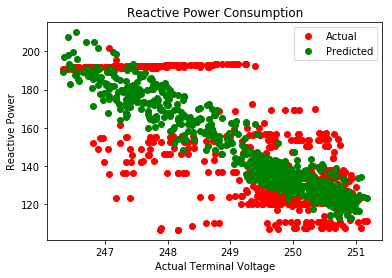

8 to 12


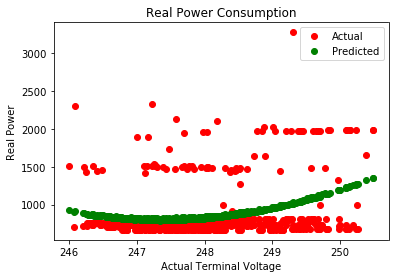

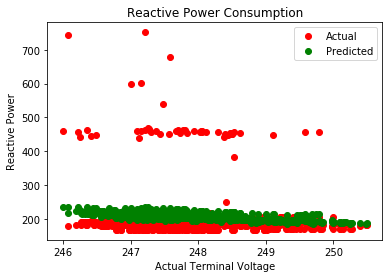

12 to 16


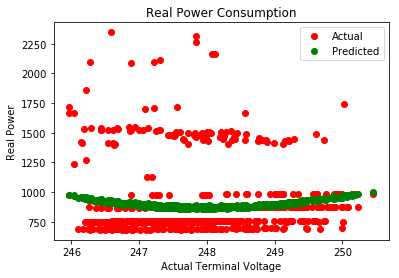

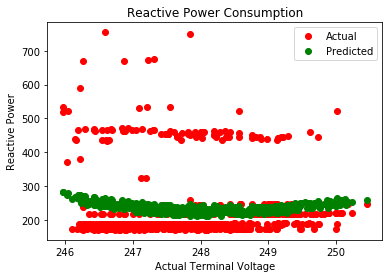

16 to 20


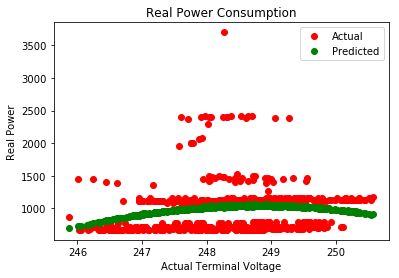

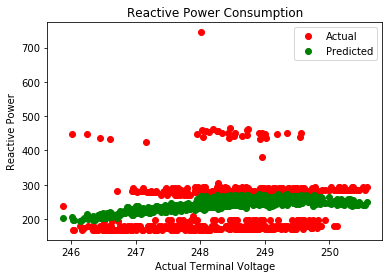

20 to 24


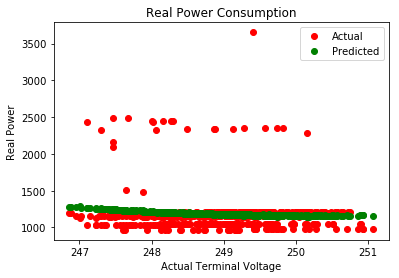

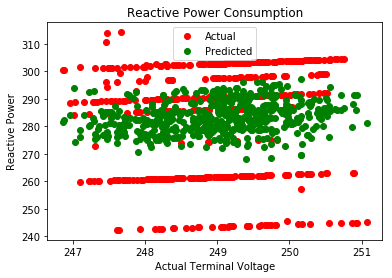

Weekends
0 to 4


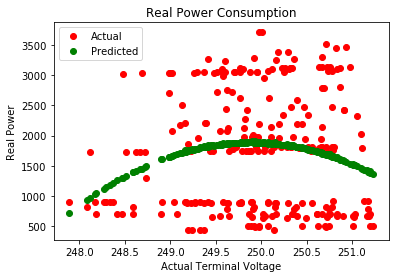

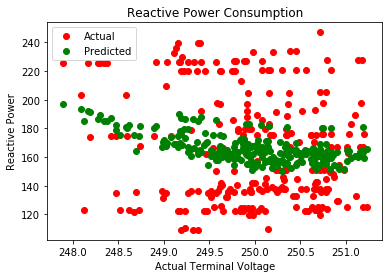

4 to 8


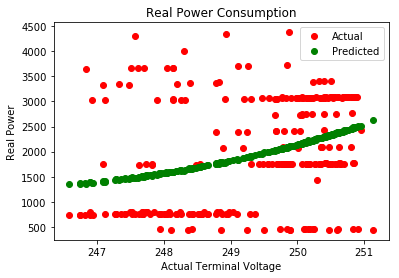

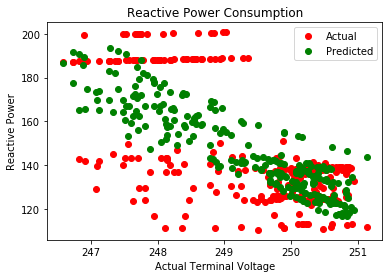

8 to 12


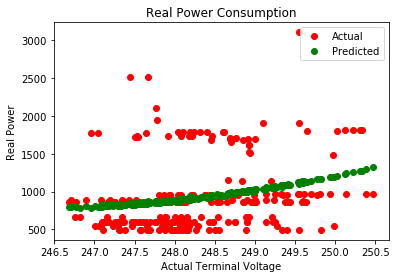

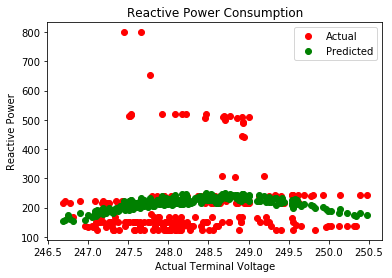

12 to 16


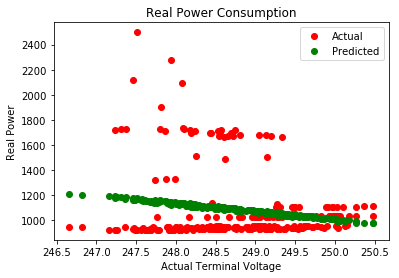

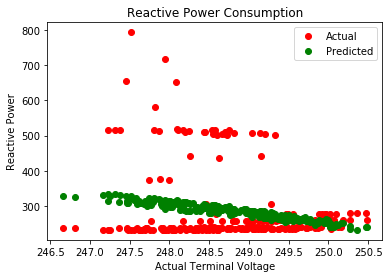

16 to 20


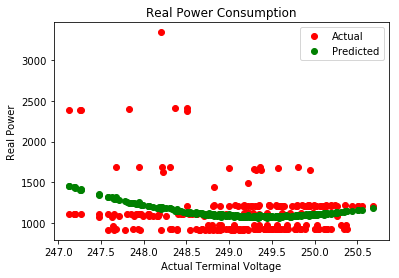

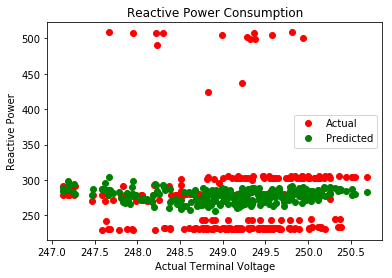

20 to 24


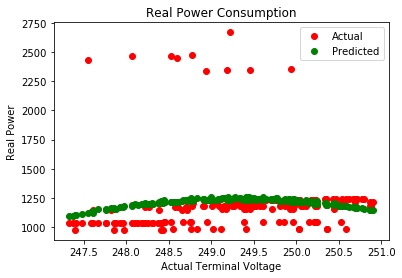

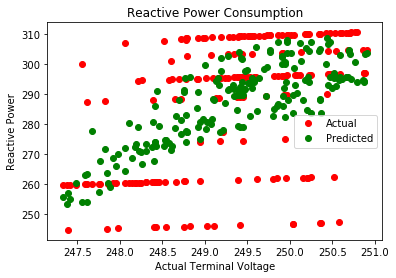

Season  2
2013-03-01
2013-05-15
Weekdays
0 to 4


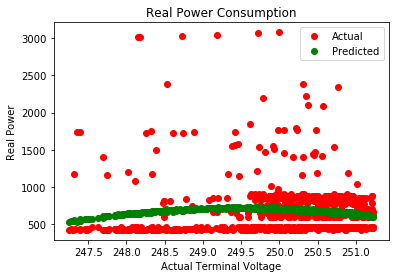

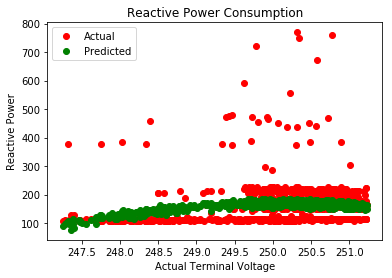

4 to 8


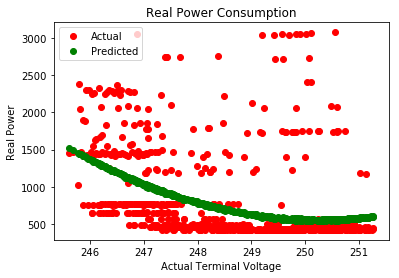

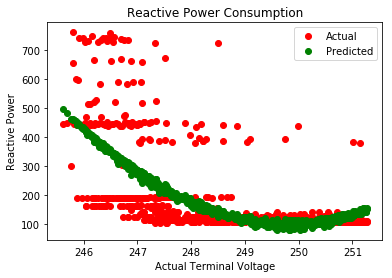

8 to 12


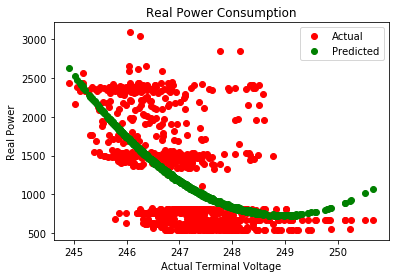

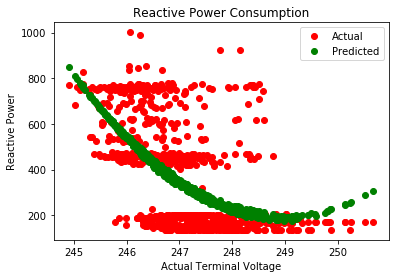

12 to 16


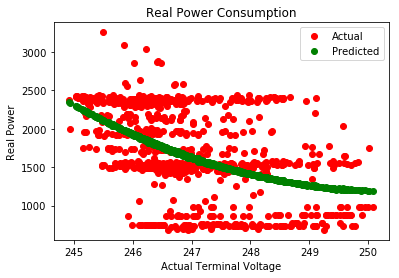

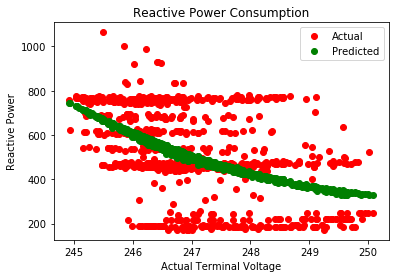

16 to 20


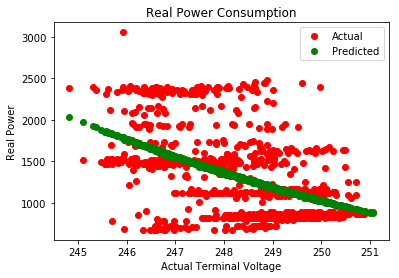

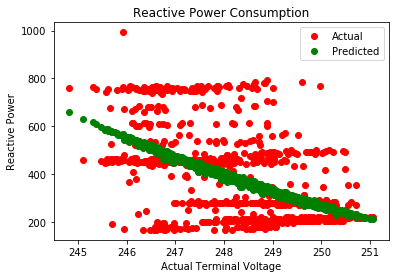

20 to 24


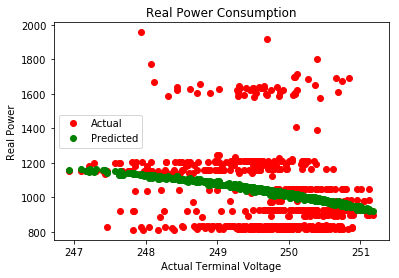

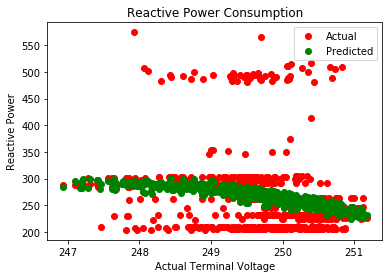

Weekends
0 to 4


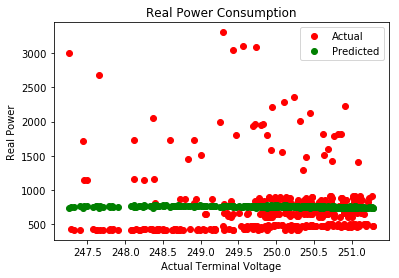

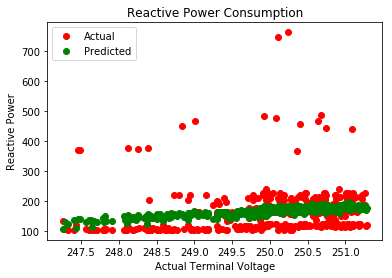

4 to 8


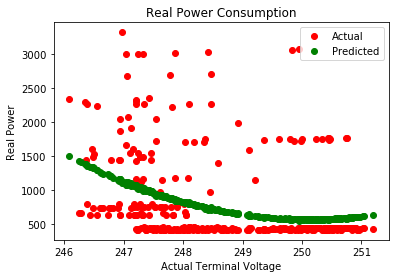

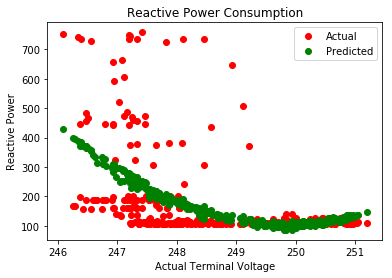

8 to 12


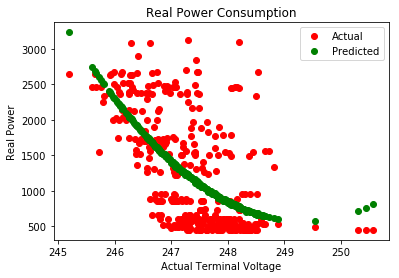

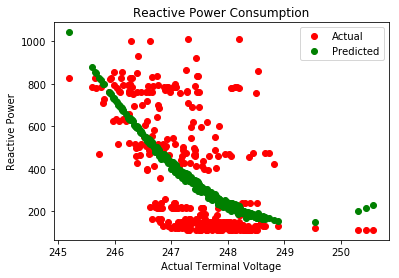

12 to 16


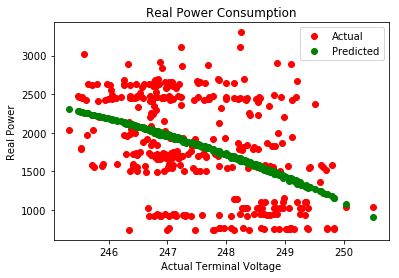

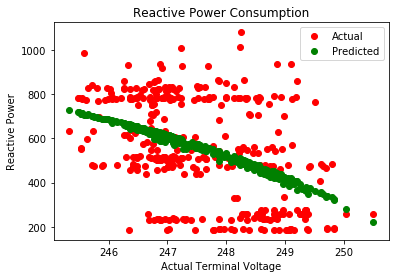

16 to 20


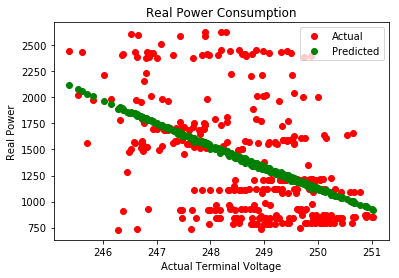

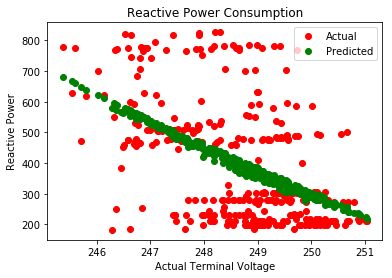

20 to 24


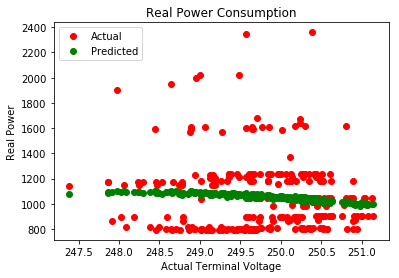

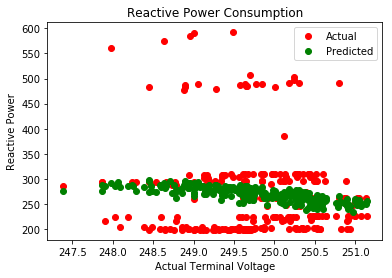

HOUR WINDOW IS 8
Season  1
2013-01-01
2013-03-01
Weekdays
0 to 8


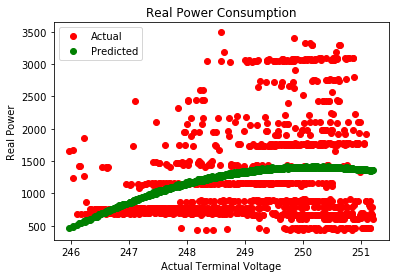

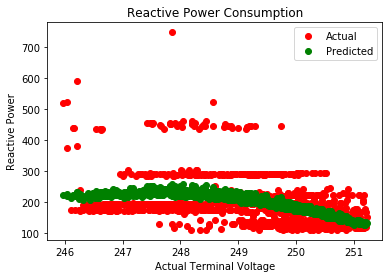

8 to 16


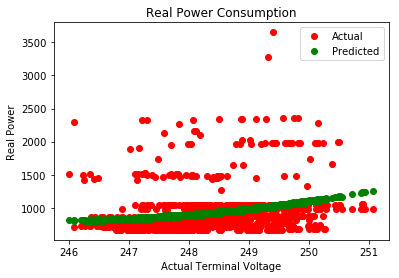

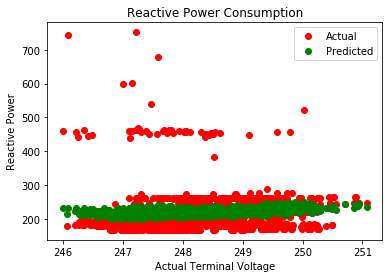

16 to 24


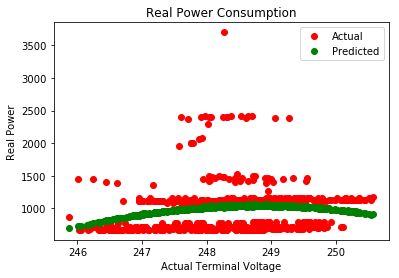

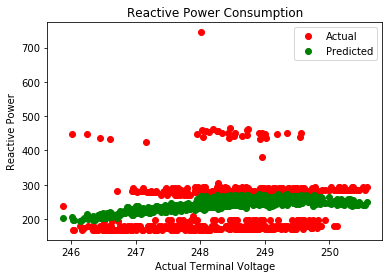

Weekends
0 to 8


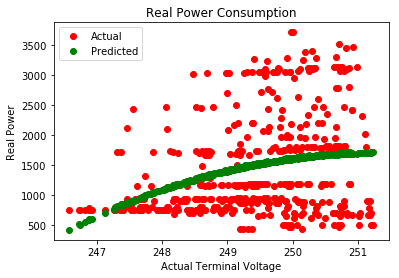

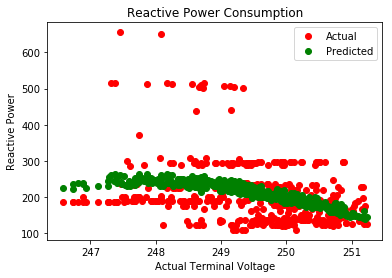

8 to 16


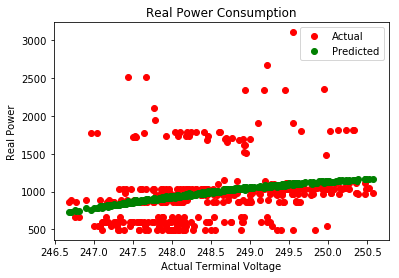

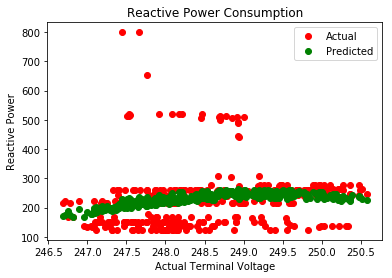

16 to 24


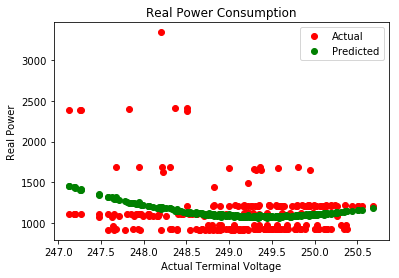

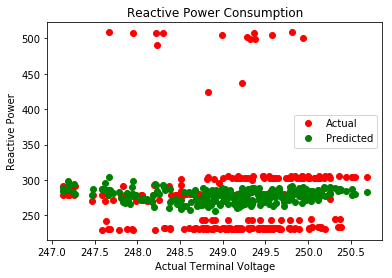

Season  2
2013-03-01
2013-05-15
Weekdays
0 to 8


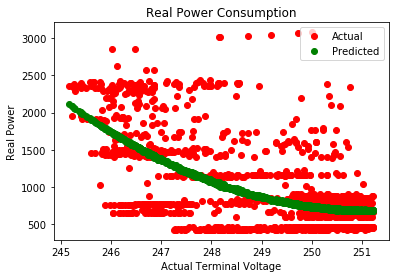

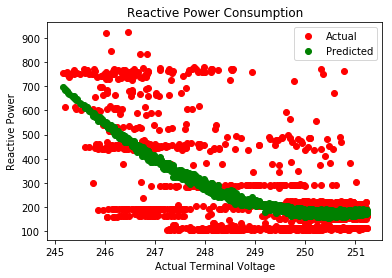

8 to 16


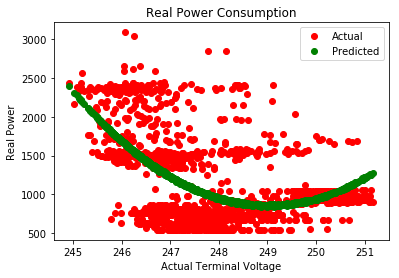

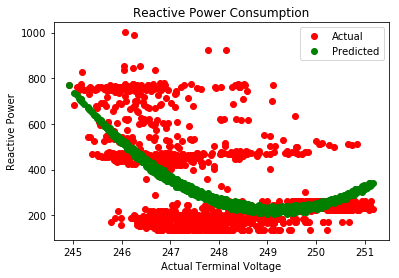

16 to 24


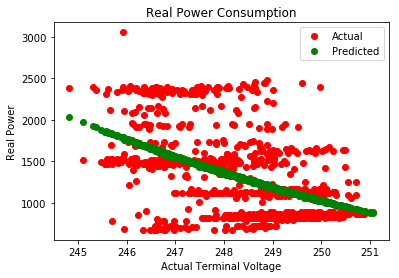

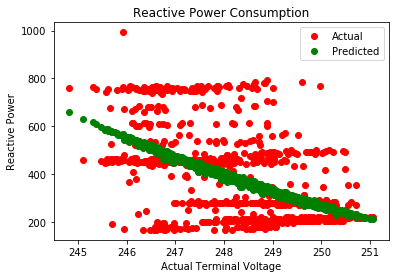

Weekends
0 to 8


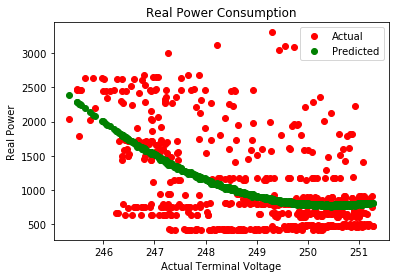

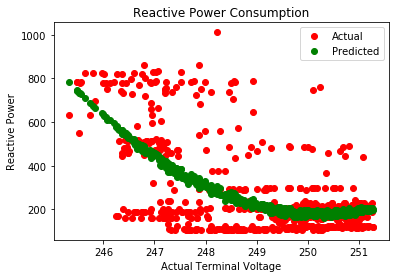

8 to 16


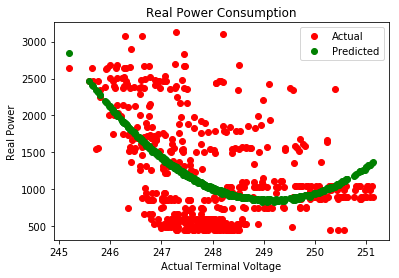

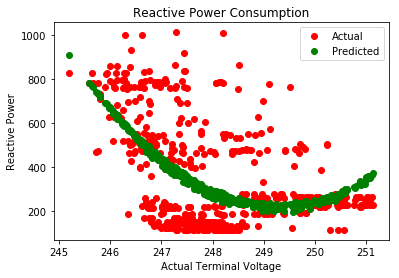

16 to 24


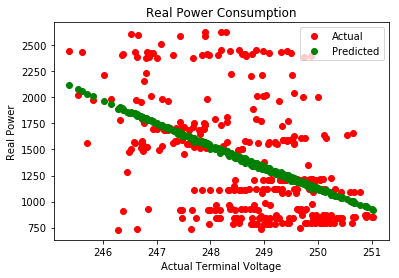

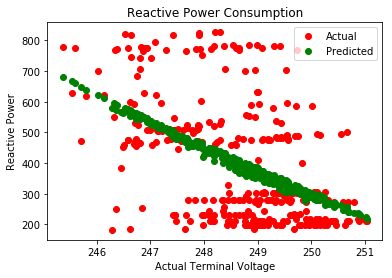

HOUR WINDOW IS 12
Season  1
2013-01-01
2013-03-01
Weekdays
0 to 12


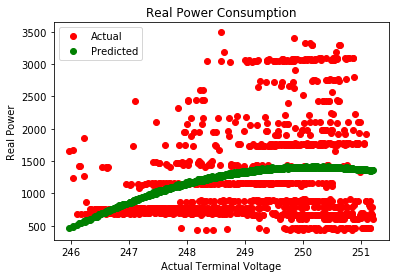

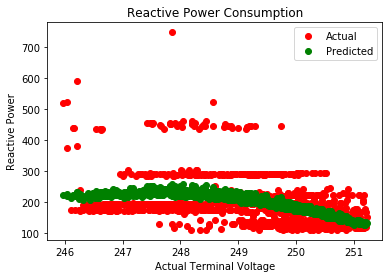

12 to 24


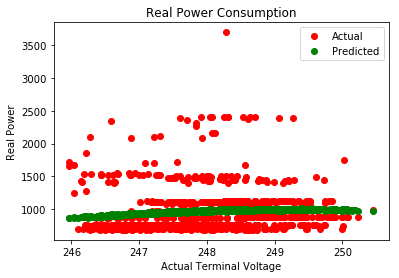

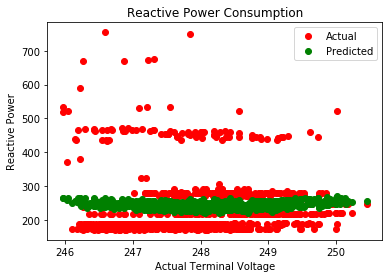

Weekends
0 to 12


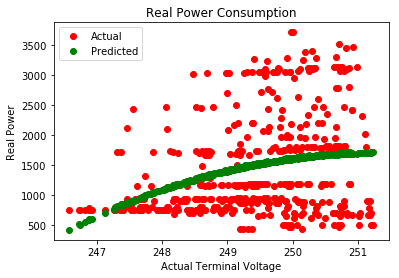

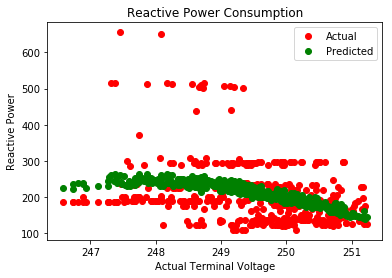

12 to 24


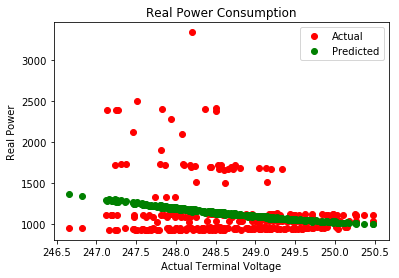

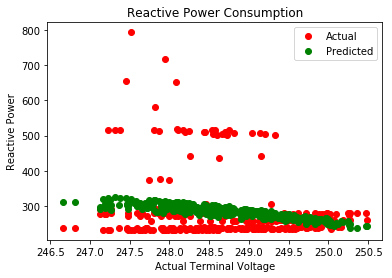

Season  2
2013-03-01
2013-05-15
Weekdays
0 to 12


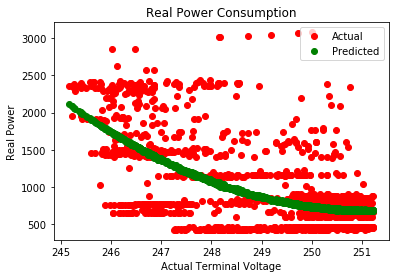

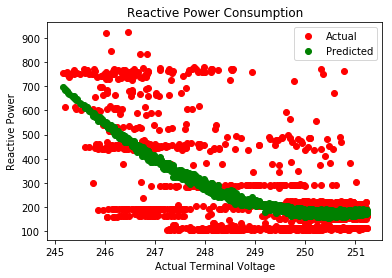

12 to 24


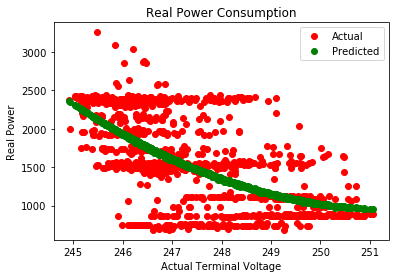

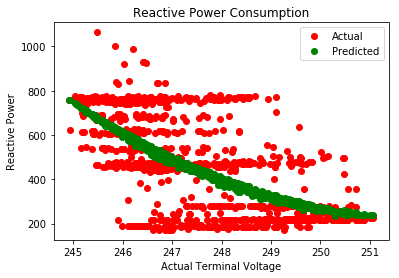

Weekends
0 to 12


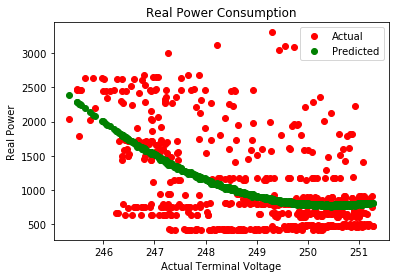

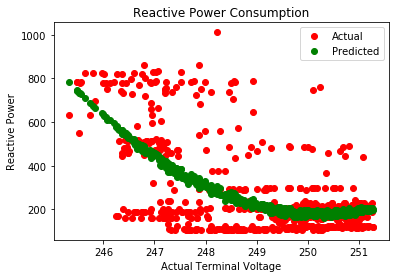

12 to 24


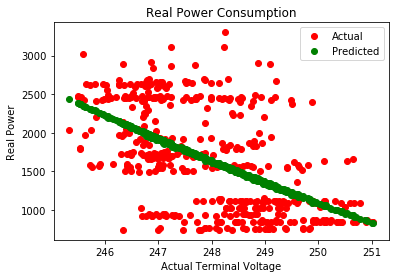

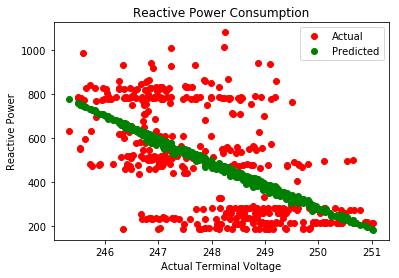

HOUR WINDOW IS 24
Season  1
2013-01-01
2013-03-01
Weekdays
0 to 24


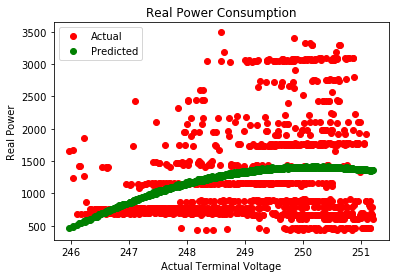

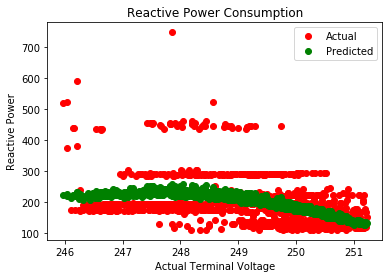

Weekends
0 to 24


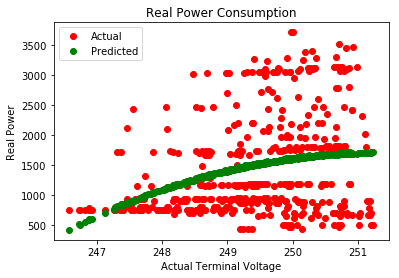

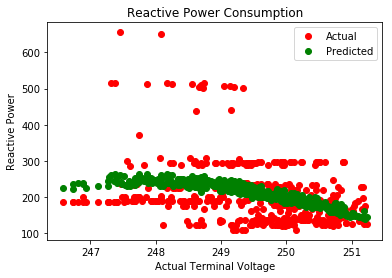

Season  2
2013-03-01
2013-05-15
Weekdays
0 to 24


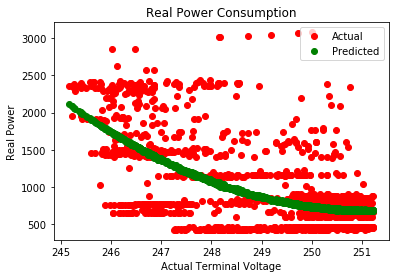

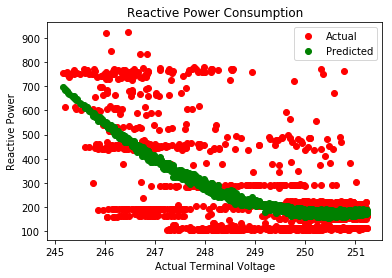

Weekends
0 to 24


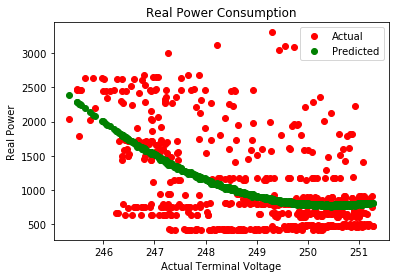

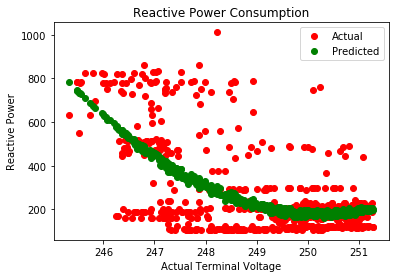

In [188]:
hourWindowDict=collections.OrderedDict()
for hourWindow in hourWindows:
    hourWindowKey="HourWindowOf"+str(hourWindow)
    print("HOUR WINDOW IS",hourWindow)
    
    seasonDict=collections.OrderedDict()
    for j in range(0,len(seasonDates)-1):
        realPowerSeason=realP[seasonDates[j]:seasonDates[j+1]]
        realVoltageSeason=realV[seasonDates[j]:seasonDates[j+1]]
        reactivePowerSeason=reactiveP[seasonDates[j]:seasonDates[j+1]]
        reactiveVoltageSeason=reactiveV[seasonDates[j]:seasonDates[j+1]]
        temperatureSeason=amiTemp[seasonDates[j]:seasonDates[j+1]]
    
        date_list=getDateList(seasonDates[j],seasonDates[j+1])
        print("Season ",j+1)
        print(seasonDates[j])
        print(seasonDates[j+1])
        seasonKey="Season"+str(j+1)
    
        dayTypeDict=collections.OrderedDict()
        for i in ('weekdays','weekends'):
            if i=='weekdays':
                dayTypeKey="weekday"
                days=[(day.strftime('%Y-%m-%d')) for day in date_list if (day.isoweekday()==1 or day.isoweekday()==2 or day.isoweekday()==3 or day.isoweekday()==4 or day.isoweekday()==5)]
                print("Weekdays")
            
            else:
                dayTypeKey="weekend"
                days=[(day.strftime('%Y-%m-%d')) for day in date_list if (day.isoweekday()==6 or day.isoweekday()==7)]
                print("Weekends")
        
            
            totalrealPower=getDays(realPowerSeason,days)
            totalrealVoltage=getDays(realVoltageSeason,days)
            totalreactivePower=getDays(reactivePowerSeason,days)
            totalreactiveVoltage=getDays(reactiveVoltageSeason,days)
            totaltemperature=getDays(temperatureSeason,days)
            
            hourDict=collections.OrderedDict()
            hr=0
            while hr <24:
                
                realPower=getHourData(totalrealPower,hourWindow,hr)
                realVoltage=getHourData(totalrealVoltage,hourWindow,hr)
                reactivePower=getHourData(totalreactivePower,hourWindow,hr)
                reactiveVoltage=getHourData(totalreactiveVoltage,hourWindow,hr)
                temperature=getHourData(totaltemperature,hourWindow,hr)

                hourKey=str(hr)+" to "+str(hr+hourWindow)
            
                print(hr,"to",hr+hourWindow)
                hr=hr+hourWindow
                apparentVoltage=((realVoltage**2)+(reactiveVoltage**2))**0.5
                apparentPower=((realPower**2)+(reactivePower**2))**0.5
                independentVariable=apparentVoltage/apparentVoltage.mean() # or .median()
                
                nominalPower= getNominalPower(apparentPower, apparentVoltage) #Sn value
    
                columnNames=independentVariable.columns
                
                t=temperature.values
                t=np.reshape(t,len(t))
                x=independentVariable[columnNames[0]]
                x=x.values
            
                xaxis=apparentVoltage[columnNames[0]]
                y1=realPower[columnNames[0]].values
            
                y2=reactivePower[columnNames[0]].values
            
                                
                #c1, covar = curve_fit(realFunc, (x,t,nominalPower), y1,maxfev=50000)#,method='lm',p0=init_vals)
                #print("NEW FUNCTION1",c1)
                coefficient1, covar = curve_fit(myfunc, (x,t), y1,maxfev=8000)#,method='lm',p0=init_vals)
                coefficient2, covar = curve_fit(myfunc, (x,t), y2,maxfev=8000)#,method='lm',p0=init_vals)
                #c2, covar = curve_fit(reactiveFunc, (x,t,nominalPower), y2,maxfev=800000)#,method='lm',p0=init_vals)
                #print("NEW FUNCTION 2",c2)
                
                xx= np.linspace(x.min(),x.max(),100)
                xxaxis=np.linspace(xaxis.min(),xaxis.max(),100)


                fid,cx = pyplot.subplots()
                cx.plot(xaxis,y1,'ro',label='Actual')
                cx.plot(xaxis,myfunc((x,t),coefficient1[0],coefficient1[1],coefficient1[2]),'go',label='Predicted')
                rms1=RMS(y1,myfunc((x,t),coefficient1[0],coefficient1[1],coefficient1[2]))
            
                cx.legend()
                cx.set_title('Real Power Consumption')
                cx.set_xlabel('Actual Terminal Voltage')
                cx.set_ylabel('Real Power')
                pyplot.show()
            
                xx= np.linspace(x.min(),x.max(),100)
                xxaxis=np.linspace(xaxis.min(),xaxis.max(),100)

                fid,cx = pyplot.subplots()
                cx.plot(xaxis,y2,'ro',label='Actual')
                cx.plot(xaxis,myfunc((x,t),coefficient2[0],coefficient2[1],coefficient2[2]),'go',label='Predicted')
                rms2=RMS(y2,myfunc((x,t),coefficient2[0],coefficient2[1],coefficient2[2]))
            
                cx.legend()
                cx.set_title('Reactive Power Consumption')
                cx.set_xlabel('Actual Terminal Voltage')
                cx.set_ylabel('Reactive Power')
                pyplot.show()
                
                finalCoefficients1,finalCoefficients2=processCoefficients(coefficient1,coefficient2,nominalPower)
                
                hourmetrics1=np.append(coefficient1,rms1)
                hourmetrics1=np.append(hourmetrics1, finalCoefficients1)
                hourmetrics2=np.append(coefficient2,rms2)
                hourmetrics2=np.append(hourmetrics2, finalCoefficients2)
                
                                
                innerDict={'real': pd.DataFrame(np.reshape(hourmetrics1,(1,len(hourmetrics1)))), 'reactive':pd.DataFrame(np.reshape(hourmetrics2,(1,len(hourmetrics2))))}
                df=pd.concat(innerDict)
                df=df.reset_index(level=1, drop=True)

                hourDict[hourKey]=df
                
            outerDF=pd.concat(hourDict)
            
            dayTypeDict[dayTypeKey]=outerDF
            
        oouterDF=pd.concat(dayTypeDict)
        seasonDict[seasonKey]=oouterDF
    seasonDF=pd.concat(seasonDict)
    hourWindowDict[hourWindowKey]=seasonDF
hourWindowDF=pd.concat(hourWindowDict)
columnNames=['coefficient1','coefficient2','coefficient3','rms','Z','I','P']
hourWindowDF.columns=columnNames

Table giving the Coefficients and the the RMSE values for different Time Window Models

In [189]:
hourWindowDF

coefficient1  coefficient2  \
HourWindowOf1 Season1 weekday 0 to 1   reactive -2.740139e+04  5.379892e+04   
                                       real      4.274008e+06 -8.560376e+06   
                              1 to 2   reactive  1.229480e+04 -2.575155e+04   
                                       real      5.792273e+03 -8.957265e+04   
                              10 to 11 reactive  1.530890e+04 -3.070203e+04   
                                       real     -1.661688e+05  3.312582e+05   
                              11 to 12 reactive -9.562425e+04  1.910325e+05   
                                       real     -2.117300e+05  4.233905e+05   
                              12 to 13 reactive  1.039879e+06 -2.087998e+06   
                                       real      3.058637e+06 -6.140587e+06   
                              13 to 14 reactive  8.320158e+05 -1.672760e+06   
                                       real      2.537802e+06 -5.101040e+06   
                              14 to 15 reactive -1.770238e+05  3.568511e+05   
                                       real     -5.021912e+05  1.011869e+06   
                              15 to 16 reactive  6.066115e+05 -1.208356e+06   
                                       real      1.679546e+06 -3.345455e+06   
                              16 to 17 reactive -1.796934e+05  3.614654e+05   
                                       real     -8.533430e+05  1.711889e+06   
                              17 to 18 reactive -4.724943e+05  9.448131e+05   
                                       real     -2.776882e+06  5.547563e+06   
                              18 to 19 reactive  2.490716e+05 -4.967276e+05   
                                       real     -3.207663e+05  6.407159e+05   
                              19 to 20 reactive  9.725039e+04 -1.942913e+05   
                                       real     -2.913752e+05  5.794371e+05   
                              2 to 3   reactive  1.587752e+05 -3.186778e+05   
                                       real      8.437340e+06 -1.696811e+07   
                              20 to 21 reactive  1.907396e+05 -3.811291e+05   
                                       real      2.229834e+06 -4.466733e+06   
                              21 to 22 reactive  8.409231e+04 -1.678572e+05   
                                       real      5.705760e+05 -1.155892e+06   
...                                                       ...           ...   
HourWindowOf4 Season2 weekend 20 to 24 reactive -1.856137e+05  3.678937e+05   
                                       real     -6.636204e+05  1.318132e+06   
                              4 to 8   reactive  1.348779e+06 -2.708935e+06   
                                       real      3.430940e+06 -6.899690e+06   
                              8 to 12  reactive  3.208321e+06 -6.466630e+06   
                                       real      9.430036e+06 -1.901067e+07   
HourWindowOf8 Season1 weekday 0 to 8   reactive -5.189701e+05  1.032398e+06   
                                       real     -3.370241e+06  6.769450e+06   
                              16 to 24 reactive -3.427022e+05  6.882798e+05   
                                       real     -2.629315e+06  5.266578e+06   
                              8 to 16  reactive  9.794498e+04 -1.942865e+05   
                                       real      9.533364e+05 -1.886050e+06   
                      weekend 0 to 8   reactive -5.165853e+05  1.026950e+06   
                                       real     -3.590468e+06  7.235152e+06   
                              16 to 24 reactive  4.664782e+05 -9.326104e+05   
                                       real      4.617993e+06 -9.247008e+06   
                              8 to 16  reactive -6.435664e+05  1.291505e+06   
                                       real     -9.240746e+05  1.877022e+06   
              Season2 weekday 0 to 8   reactive  1.076799e+06 -2.166259e+06   
                    